In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import xarray
from tqdm.notebook import tqdm
import seaborn as sns
%matplotlib inline
from sklearn.impute import KNNImputer
# Modelagem do RF
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Análise dos dados gerados
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
import contextily as ctx

### Adiquirindo os Dados

In [2]:
df = pd.read_csv('E:/ML_RS/Qgis/Passo_feio/df_pf_gam_mdt_lsat.csv',
                 header=0, 
                 usecols='fid,lon,lat,TC,Kperc,eU,eTh,U_Th,U_K,Th_K,MDT,COD_UNI_ES,SIGLA_UNID,LS9_B6_SWIR,LS9_B5_NIR,LS9_B4_Red,LS9_B3_Green,LS9_B2_Blue,LS9_B7_SWIR2,LS9_RGB_Falsacor_1,LS9_RGB_Falsacor_2,LS9_RGB_Falsacor_3'.split(','),
                 low_memory=False)

# Conversão para GeoDataFrame
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:31982")  # SIRGAS 2000 / UTM zone 22S

# Mantenha 'df' também para compatibilidade (opcional)
df = gdf  

In [3]:
column_names = "fid lon lat TC Kperc eU eTh U_Th U_K Th_K MDT COD_UNI_ES SIGLA_UNID LS9_B6_SWIR LS9_B5_NIR LS9_B4_Red LS9_B3_Green LS9_B2_Blue LS9_B7_SWIR2 LS9_RGB_Falsacor_1 LS9_RGB_Falsacor_2 LS9_RGB_Falsacor_3 NDVI geometry".split(' ')
column_names


['fid',
 'lon',
 'lat',
 'TC',
 'Kperc',
 'eU',
 'eTh',
 'U_Th',
 'U_K',
 'Th_K',
 'MDT',
 'COD_UNI_ES',
 'SIGLA_UNID',
 'LS9_B6_SWIR',
 'LS9_B5_NIR',
 'LS9_B4_Red',
 'LS9_B3_Green',
 'LS9_B2_Blue',
 'LS9_B7_SWIR2',
 'LS9_RGB_Falsacor_1',
 'LS9_RGB_Falsacor_2',
 'LS9_RGB_Falsacor_3',
 'NDVI',
 'geometry']

### Visualização dos Dados

In [4]:
df.describe()

fid          lon          lat           TC        Kperc  \
count  6480.000000  6480.000000  6480.000000  6480.000000  6480.000000   
mean   3240.500000   -53.564996   -30.635005     0.500039     0.494855   
std    1870.759204     0.037876     0.079246     0.289611     0.288567   
min       1.000000   -53.629990   -30.769983     0.000044     0.000004   
25%    1620.750000   -53.597493   -30.702494     0.248856     0.244507   
50%    3240.500000   -53.564996   -30.635005     0.499756     0.492584   
75%    4860.250000   -53.532499   -30.567516     0.750780     0.744987   
max    6480.000000   -53.500002   -30.500027     0.999761     0.999953   

                eU          eTh         U_Th          U_K          Th_K  ...  \
count  6480.000000  6480.000000  6480.000000  6480.000000   6480.000000  ...   
mean      0.501498     0.489132     5.329372     7.485620     12.198262  ...   
std       0.286502     0.288364    98.575916   150.306415    589.482663  ...   
min       0.000505     0.000029     0.000717     0.000718      0.000067  ...   
25%       0.255996     0.237625     0.510615     0.517667      0.493398  ...   
50%       0.506608     0.476460     1.027505     1.010362      0.995360  ...   
75%       0.746949     0.738907     2.101909     2.038083      1.985643  ...   
max       0.999603     0.999844  7550.956899  9793.230459  47292.650373  ...   

        COD_UNI_ES   LS9_B6_SWIR    LS9_B5_NIR    LS9_B4_Red  LS9_B3_Green  \
count  6237.000000   6253.000000   6253.000000   6253.000000   6253.000000   
mean   2217.307520  10252.115625  17495.964017   8599.580681   8984.144091   
std    1591.257019   1219.420879   2733.728247    595.341097    599.665233   
min     135.000000   7397.000000   7687.000000   7315.000000   7477.000000   
25%     152.000000   9328.000000  15758.000000   8148.000000   8513.000000   
50%    2711.000000  10181.000000  17556.000000   8525.000000   8949.000000   
75%    3661.000000  11062.000000  19270.000000   8970.000000   9421.000000   
max    7252.000000  15615.000000  27315.000000  12372.000000  11667.000000   

        LS9_B2_Blue  LS9_B7_SWIR2  LS9_RGB_Falsacor_1  LS9_RGB_Falsacor_2  \
count   6253.000000   6253.000000         6455.000000         6455.000000   
mean    8111.893171  10252.115625           63.807591           87.724555   
std      310.157696   1219.420879           15.944361           19.107456   
min     7334.000000   7397.000000            0.000000            0.000000   
25%     7885.000000   9328.000000           58.500000           84.000000   
50%     8096.000000  10181.000000           66.000000           91.000000   
75%     8308.000000  11062.000000           74.000000           98.000000   
max    10137.000000  15615.000000           98.000000          125.000000   

       LS9_RGB_Falsacor_3  
count         6455.000000  
mean            39.584198  
std              9.962013  
min              0.000000  
25%             36.000000  
50%             41.000000  
75%             45.000000  
max             65.000000  

[8 rows x 21 columns]

### Organização e visualização dos dados

In [5]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6480 entries, 0 to 6479
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   fid                 6480 non-null   int64   
 1   lon                 6480 non-null   float64 
 2   lat                 6480 non-null   float64 
 3   TC                  6480 non-null   float64 
 4   Kperc               6480 non-null   float64 
 5   eU                  6480 non-null   float64 
 6   eTh                 6480 non-null   float64 
 7   U_Th                6480 non-null   float64 
 8   U_K                 6480 non-null   float64 
 9   Th_K                6480 non-null   float64 
 10  MDT                 6195 non-null   float64 
 11  COD_UNI_ES          6237 non-null   float64 
 12  SIGLA_UNID          6237 non-null   object  
 13  LS9_B6_SWIR         6253 non-null   float64 
 14  LS9_B5_NIR          6253 non-null   float64 
 15  LS9_B4_Red          6253 non-n

### Limpando os dados

In [6]:
# 1. Separar colunas por tipo e significado (mantendo sua estrutura original)
geo_cols = ['lon', 'lat', 'MDT']
radiometric_cols = ['TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K']
spectral_cols = [c for c in df.columns if 'LS9_' in c]
categorical_cols = ['SIGLA_UNID']
id_cols = ['fid', 'COD_UNI_ES']

# 2. Tratamento para dados categóricos - REMOVER NAs em vez de criar UNKNOWN
print("Distribuição original de SIGLA_UNID:\n", df['SIGLA_UNID'].value_counts())
print(f"\nLinhas com SIGLA_UNID faltante: {df['SIGLA_UNID'].isna().sum()}")

# Remover linhas onde SIGLA_UNID é NA 
df = df.dropna(subset=['SIGLA_UNID']).copy()
print("\nDistribuição após remoção:\n", df['SIGLA_UNID'].value_counts())

# 3. Tratamento diferenciado para variáveis numéricas

# A. Dados Geoespaciais - interpolação espacial condicional
# (só preenche se tiver pelo menos 2 pontos válidos)
for col in geo_cols:
    if df[col].isna().sum() > 0:
        df[col] = df[col].interpolate(method='linear')
        # Se ainda houver NAs (pontos nas extremidades), remove
        df = df.dropna(subset=[col])

# B. Dados Radiométricos - imputação robusta com verificação

if df[radiometric_cols].isna().sum().sum() > 0:
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    df[radiometric_cols] = imputer.fit_transform(df[radiometric_cols])

# C. Bandas Espectrais - normalização + interpolação

scaler = RobustScaler()
df[spectral_cols] = scaler.fit_transform(df[spectral_cols])

# Preencher eventuais NAs restantes (se houver)
df[spectral_cols] = df[spectral_cols].interpolate(method='linear', limit_direction='both')

# 4. Engenharia de features geoespaciais melhorada
# NDVI com verificação de divisão por zero
df['NDVI'] = (df['LS9_B5_NIR'] - df['LS9_B4_Red']) / (df['LS9_B5_NIR'] + df['LS9_B4_Red'] + 1e-10)
df['NDVI'] = df['NDVI'].clip(-1, 1)  # Garantir valores dentro do range teórico

# Razões entre bandas com proteção contra outliers
def safe_ratio(a, b, max_val=10):
    ratio = a / (b + 1e-10)
    return np.clip(ratio, -max_val, max_val)

df['Ratio_B5_B4'] = safe_ratio(df['LS9_B5_NIR'], df['LS9_B4_Red'])
df['Ratio_B7_B6'] = safe_ratio(df['LS9_B7_SWIR2'], df['LS9_B6_SWIR'])

# 5. Verificação final rigorosa
print("\nValores faltantes após tratamento:")
print(df.isna().sum())

# Verificação de valores extremos
def check_outliers(col, threshold=3):
    z_scores = (df[col] - df[col].mean()) / df[col].std()
    return df[abs(z_scores) > threshold][[col]]

print("\nValores extremos em U_Th:")
print(check_outliers('U_Th'))

# Verificação geoespacial
print(f"\nMDT range: {df['MDT'].min():.2f} to {df['MDT'].max():.2f}")
print(f"Coordenadas únicas: {df[['lon','lat']].drop_duplicates().shape[0]} de {len(df)} pontos")

Distribuição original de SIGLA_UNID:
 SIGLA_UNID
NP12vpf             1277
NP3sl                851
NP3sf                663
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3ps                508
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
NP12vpfc              87
NP12vpfm              22
Name: count, dtype: int64

Linhas com SIGLA_UNID faltante: 243

Distribuição após remoção:
 SIGLA_UNID
NP12vpf             1277
NP3sl                851
NP3sf                663
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3ps                508
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
NP12vpfc              87
NP12vpfm              22
Name: count, dtype: int64

Valores faltantes após tratamento:
fid                   0
lon                   0
lat                   0
TC                    0
Kperc                 0
eU                    0
eTh                   0
U_Th              

### Verificações para evitar erros futuros

In [7]:
# Verifique NaN/inf nas colunas geoespaciais
print("Valores faltantes antes da interpolação:")
print(df[geo_cols].isna().sum())

# Verifique infinitos
print("Valores infinitos:")
print(np.isinf(df[geo_cols]).sum())

Valores faltantes antes da interpolação:
lon    0
lat    0
MDT    0
dtype: int64
Valores infinitos:
lon    0
lat    0
MDT    0
dtype: int64


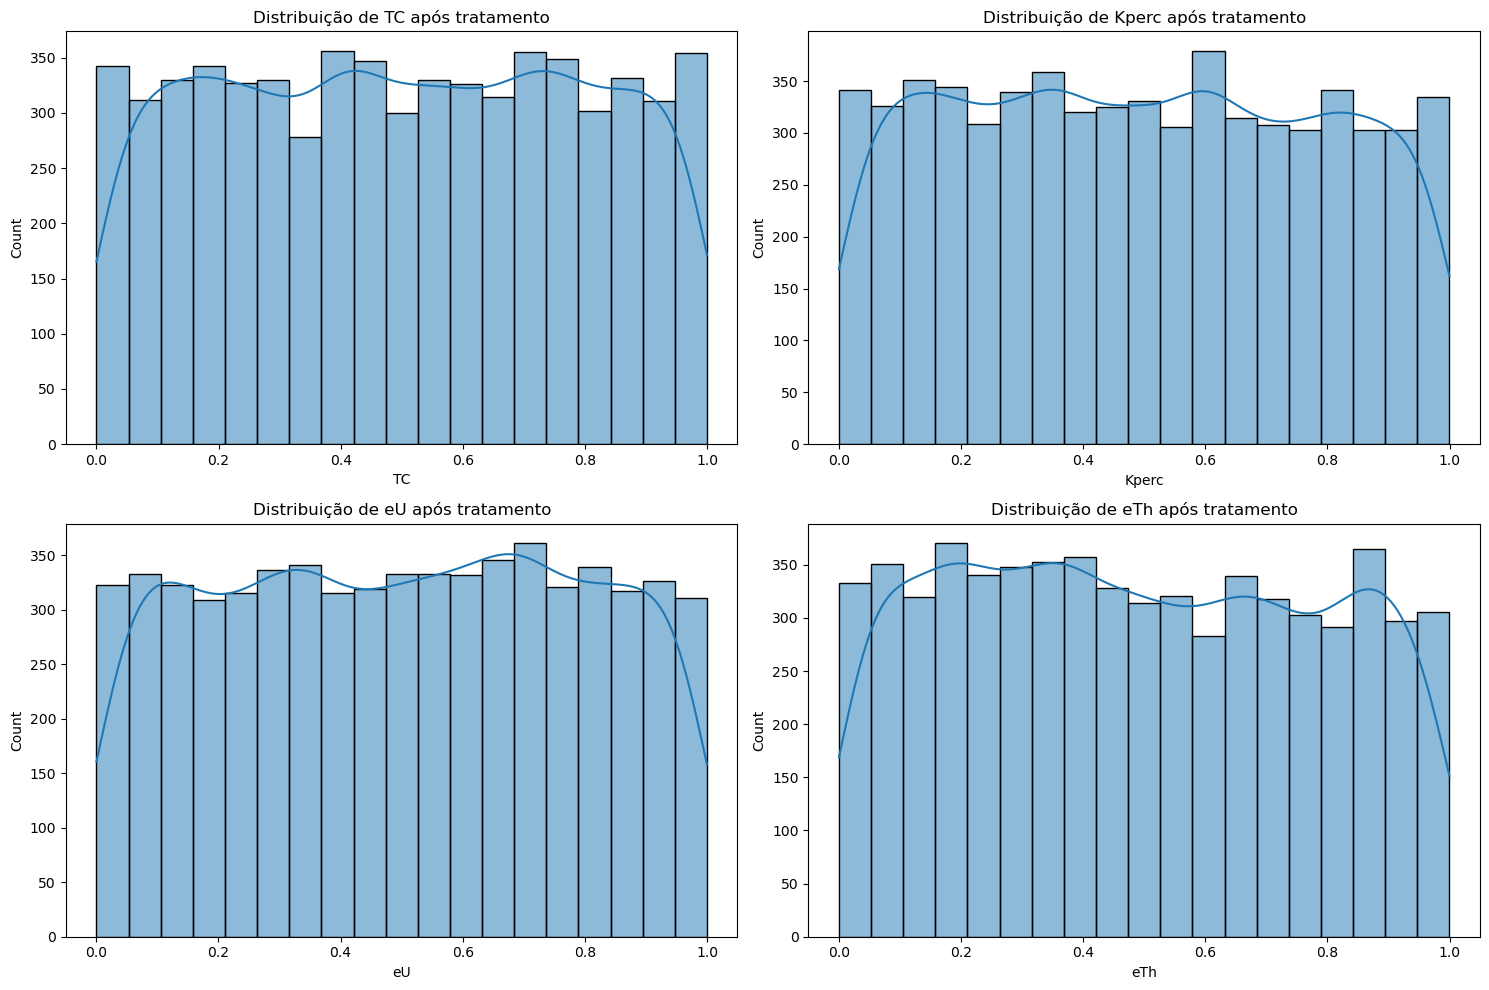

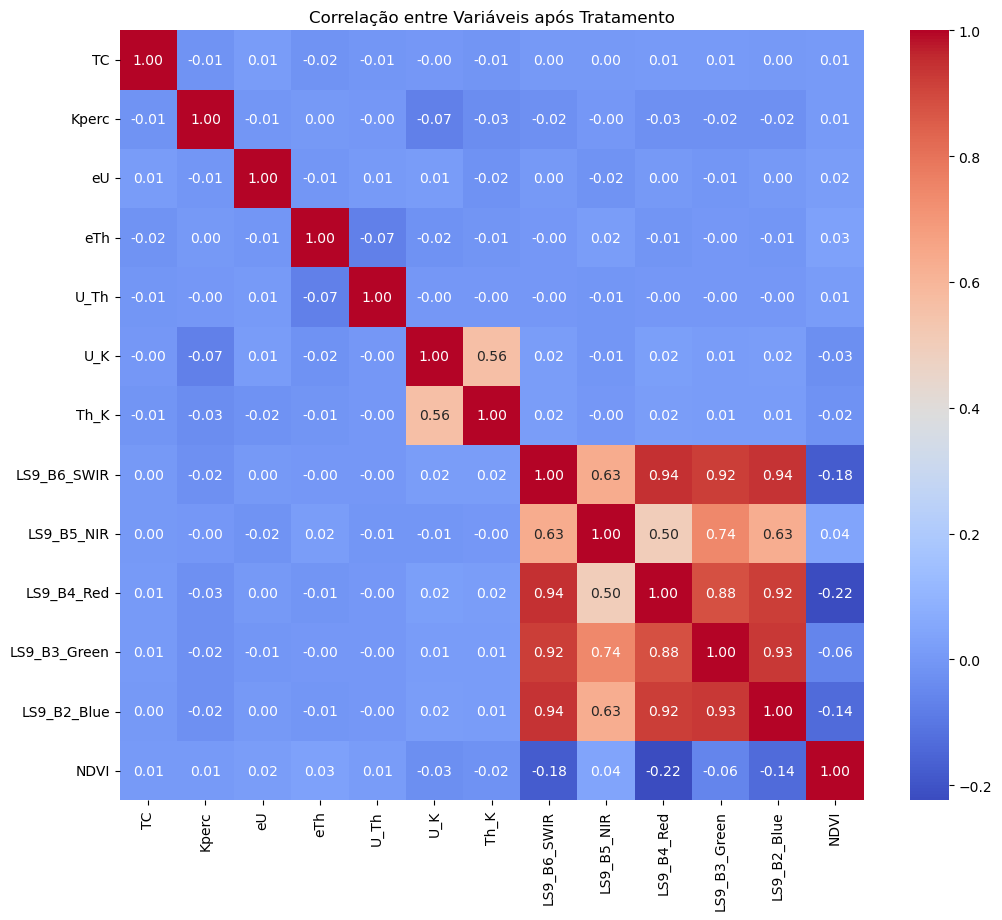

SIGLA_UNID
NP12vpf             1277
NP3sl                851
NP3sf                663
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3ps                508
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
NP12vpfc              87
NP12vpfm              22
Name: count, dtype: int64


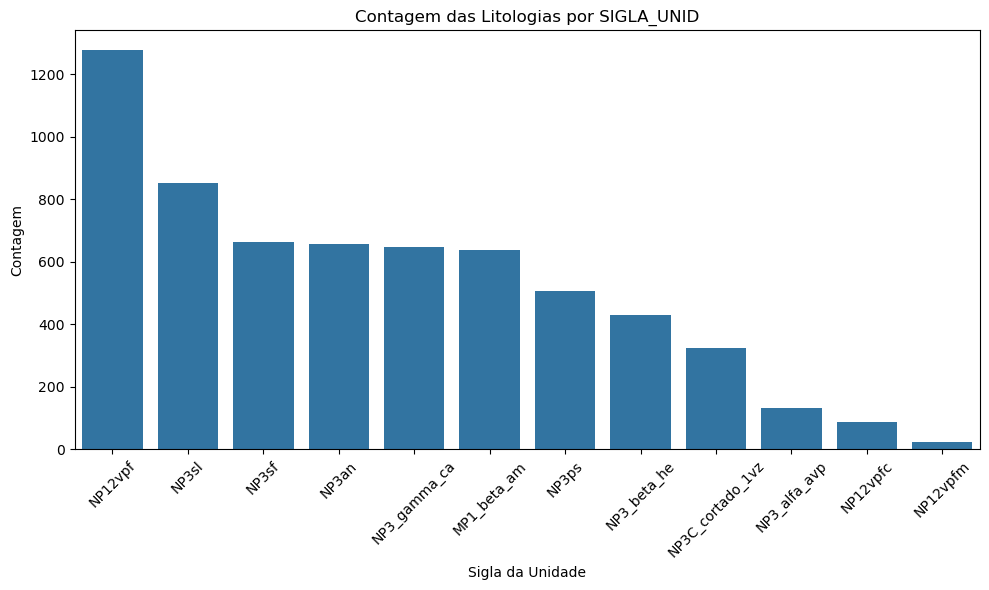

In [8]:
# 1. Verifique distribuições das variáveis tratadas
plt.figure(figsize=(15, 10))
for i, col in enumerate(radiometric_cols[:4], 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição de {col} após tratamento')
plt.tight_layout()
plt.show()

# 2. Mapa de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(df[radiometric_cols + spectral_cols[:5] + ['NDVI']].corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlação entre Variáveis após Tratamento')
plt.show()

contagem_dos_locais = df['SIGLA_UNID'].value_counts()
print(contagem_dos_locais)
# Criar o gráfico de barras
plt.figure(figsize=(10, 6)) 
sns.barplot(x=contagem_dos_locais.index, y=contagem_dos_locais.values)

# Adicionar títulos e formatação
plt.title('Contagem das Litologias por SIGLA_UNID')
plt.xlabel('Sigla da Unidade')
plt.ylabel('Contagem')
plt.xticks(rotation=45) 
# Mostrar o gráfico
plt.tight_layout() 
plt.show()

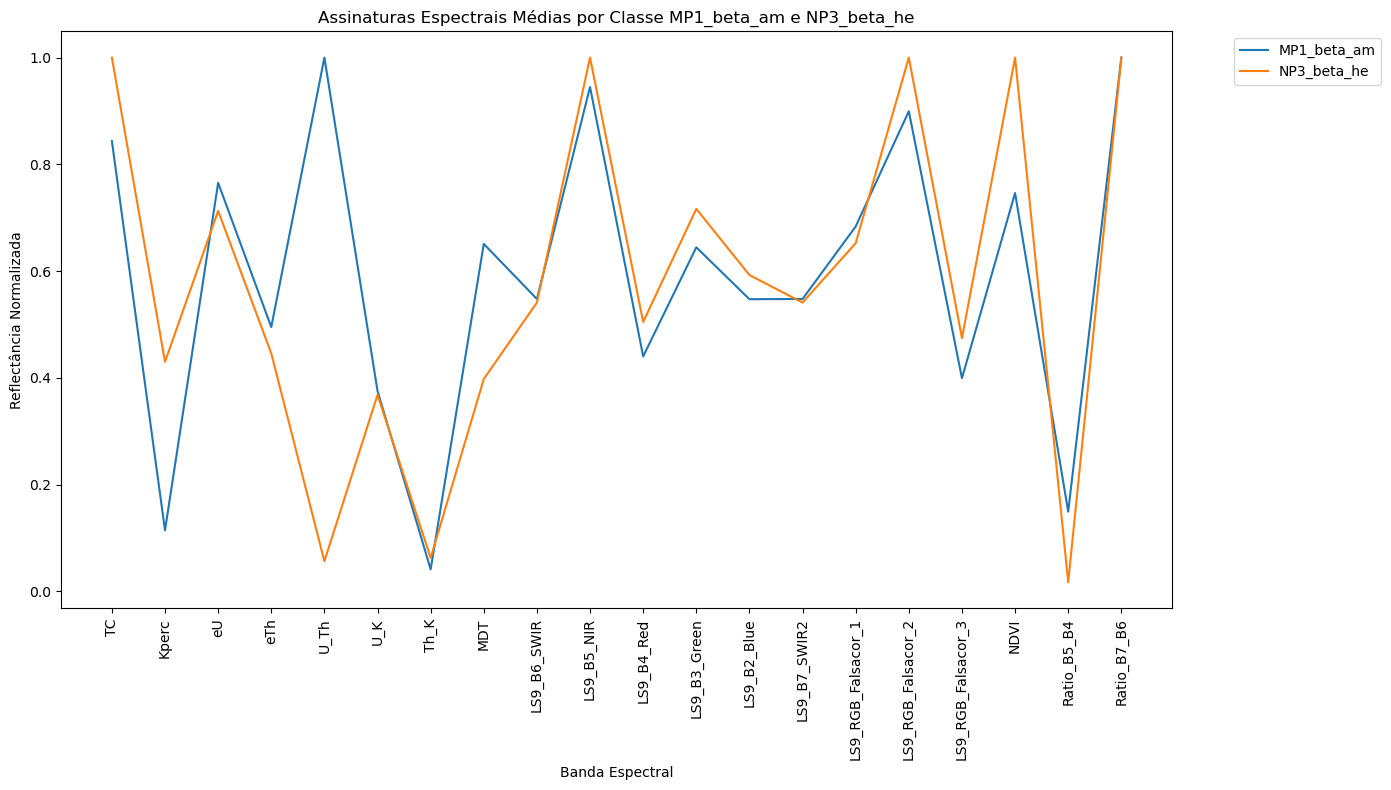

In [9]:
# Calcular médias por classe (excluindo colunas não espectrais)
spectral_bands = [col for col in df.columns if col not in ['SIGLA_UNID', 'COD_UNI_ES', 'fid', 'lon', 'lat', 'geometry']]
class_means = df.groupby('SIGLA_UNID')[spectral_bands].mean()

# Normalizar para comparação
class_means_norm = (class_means - class_means.min()) / (class_means.max() - class_means.min())

# Lista das classes que você quer plotar
classes_para_plotar = ['MP1_beta_am', 'NP3_beta_he'] # Substitua pelas classes desejadas

# Filtrar o DataFrame normalizado pelas classes de interesse
class_means_filtrado = class_means_norm.loc[classes_para_plotar]

# Plot
plt.figure(figsize=(14, 8))
for cls in class_means_filtrado.index:
    plt.plot(class_means_filtrado.columns, class_means_filtrado.loc[cls], label=cls)
plt.xticks(rotation=90)
plt.xlabel('Banda Espectral')
plt.ylabel('Reflectância Normalizada')
plt.title('Assinaturas Espectrais Médias por Classe MP1_beta_am e NP3_beta_he')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

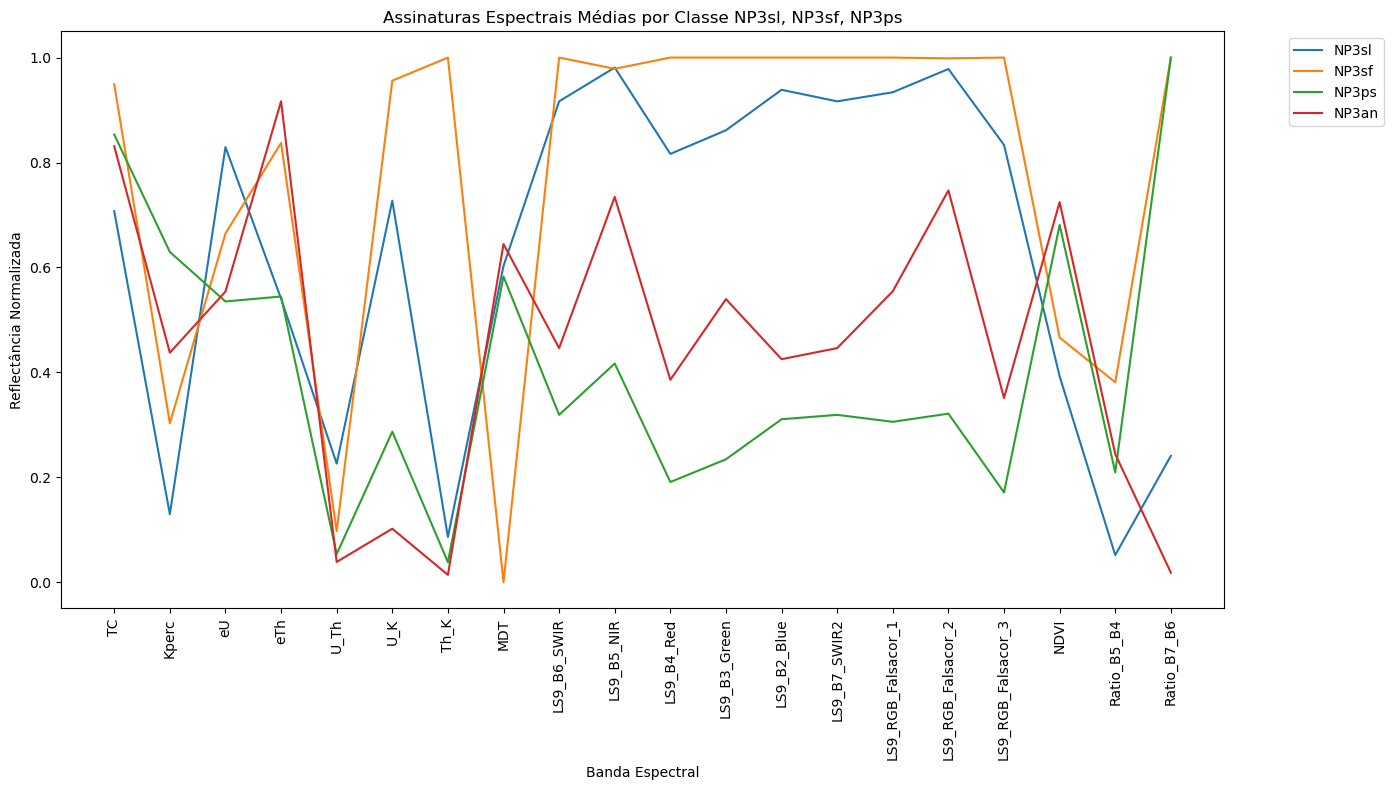

In [10]:
# Calcular médias por classe (excluindo colunas não espectrais)
spectral_bands = [col for col in df.columns if col not in ['SIGLA_UNID', 'COD_UNI_ES', 'fid', 'lon', 'lat', 'geometry']]
class_means = df.groupby('SIGLA_UNID')[spectral_bands].mean()

# Normalizar para comparação
class_means_norm = (class_means - class_means.min()) / (class_means.max() - class_means.min())

# Lista das classes que você quer plotar
classes_para_plotar = ['NP3sl', 'NP3sf', 'NP3ps', 'NP3an'] # Substitua pelas classes desejadas

# Filtrar o DataFrame normalizado pelas classes de interesse
class_means_filtrado = class_means_norm.loc[classes_para_plotar]

# Plot
plt.figure(figsize=(14, 8))
for cls in class_means_filtrado.index:
    plt.plot(class_means_filtrado.columns, class_means_filtrado.loc[cls], label=cls)
plt.xticks(rotation=90)
plt.xlabel('Banda Espectral')
plt.ylabel('Reflectância Normalizada')
plt.title('Assinaturas Espectrais Médias por Classe NP3sl, NP3sf, NP3ps')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

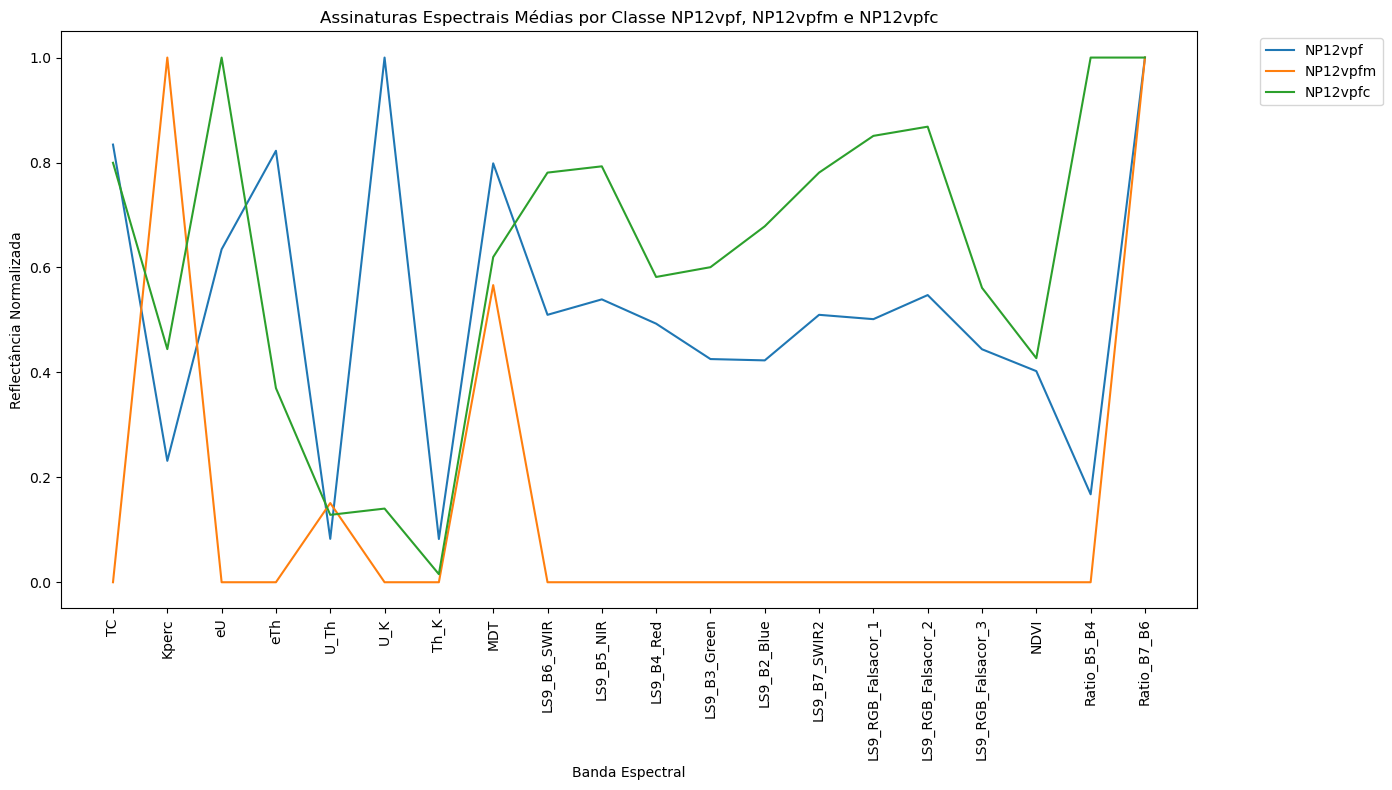

In [11]:
# Calcular médias por classe (excluindo colunas não espectrais)
spectral_bands = [col for col in df.columns if col not in ['SIGLA_UNID', 'COD_UNI_ES', 'fid', 'lon', 'lat', 'geometry']]
class_means = df.groupby('SIGLA_UNID')[spectral_bands].mean()

# Normalizar para comparação
class_means_norm = (class_means - class_means.min()) / (class_means.max() - class_means.min())

# Lista das classes que você quer plotar
classes_para_plotar = ['NP12vpf', 'NP12vpfm', 'NP12vpfc'] # Substitua pelas classes desejadas

# Filtrar o DataFrame normalizado pelas classes de interesse
class_means_filtrado = class_means_norm.loc[classes_para_plotar]

# Plot
plt.figure(figsize=(14, 8))
for cls in class_means_filtrado.index:
    plt.plot(class_means_filtrado.columns, class_means_filtrado.loc[cls], label=cls)
plt.xticks(rotation=90)
plt.xlabel('Banda Espectral')
plt.ylabel('Reflectância Normalizada')
plt.title('Assinaturas Espectrais Médias por Classe NP12vpf, NP12vpfm e NP12vpfc')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Agregação de Classes 

SIGLA_AGG
NP3ps               2022
NP12vpf             1386
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
Name: count, dtype: int64


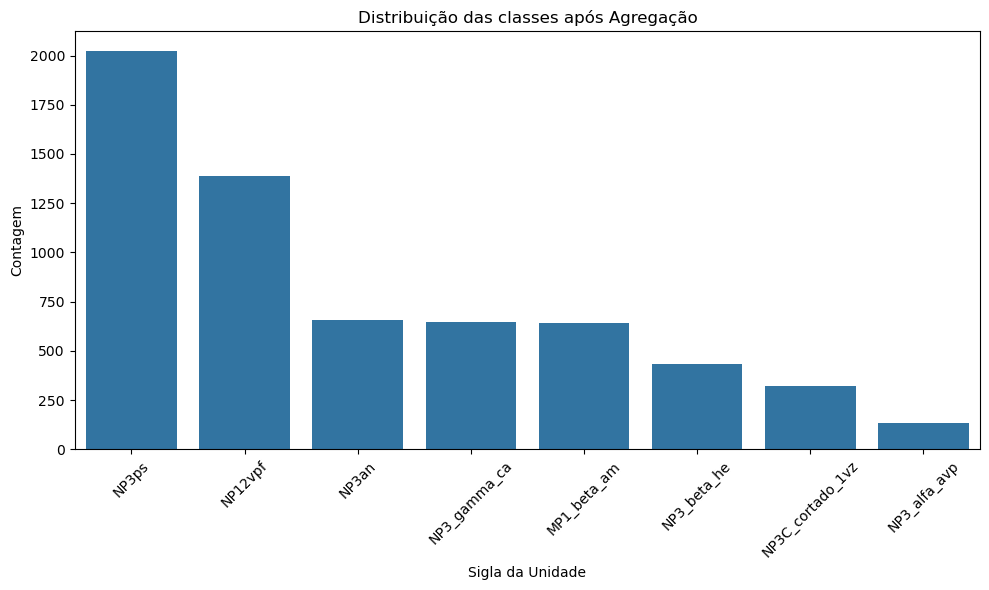

In [12]:
regras_agreg = {
    #Junção das classes do COMPLEXO PASSO FEIO (NP12vpf)
    'NP12vpfc': 'NP12vpf', 
    'NP12vpfm': 'NP12vpf',   
    
    # Junção das classes do Grupo Santa Bárbara (NP3ps)
     'NP3sl': 'NP3ps', 
     'NP3sf': 'NP3ps',
     
 }

# Criar nova coluna com classes agregadas
df['SIGLA_AGG'] = df['SIGLA_UNID'].replace(regras_agreg)

contagem_dos_locais = df['SIGLA_AGG'].value_counts()
print(contagem_dos_locais)

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))  # Ajuste o tamanho conforme necessário
sns.barplot(x=contagem_dos_locais.index, y=contagem_dos_locais.values)

# Adicionar títulos e formatação
plt.title('Distribuição das classes após Agregação')
plt.xlabel('Sigla da Unidade')
plt.ylabel('Contagem')
plt.xticks(rotation=45)  # Rotaciona os rótulos para melhor legibilidade

# Mostrar o gráfico
plt.tight_layout()  # Ajusta o layout para evitar cortes
plt.show()

In [13]:
area_status = df.groupby('SIGLA_AGG')[['TC', 'Kperc', 'eU', 'eTh', 'MDT']].describe()
print(area_status)

                      TC                                                    \
                   count      mean       std       min       25%       50%   
SIGLA_AGG                                                                    
MP1_beta_am        639.0  0.501287  0.285977  0.000549  0.258482  0.500463   
NP12vpf           1386.0  0.497534  0.296170  0.000447  0.227187  0.503339   
NP3C_cortado_1vz   323.0  0.487520  0.284093  0.004327  0.252284  0.460667   
NP3_alfa_avp       132.0  0.523412  0.295286  0.007194  0.265876  0.524392   
NP3_beta_he        431.0  0.524860  0.293014  0.001415  0.287212  0.536575   
NP3_gamma_ca       646.0  0.505011  0.297782  0.000746  0.241469  0.494080   
NP3an              658.0  0.499369  0.278096  0.002206  0.250986  0.516477   
NP3ps             2022.0  0.498210  0.286626  0.000044  0.253194  0.493283   

                                       Kperc            ...       eTh  \
                       75%       max   count      mean  ...       75

### Visulaização espacial após a agregação das litologias

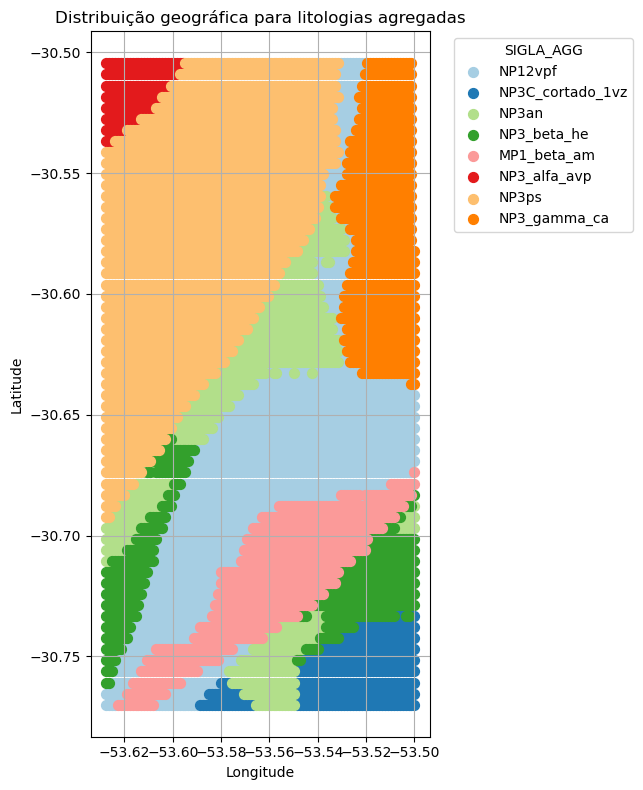

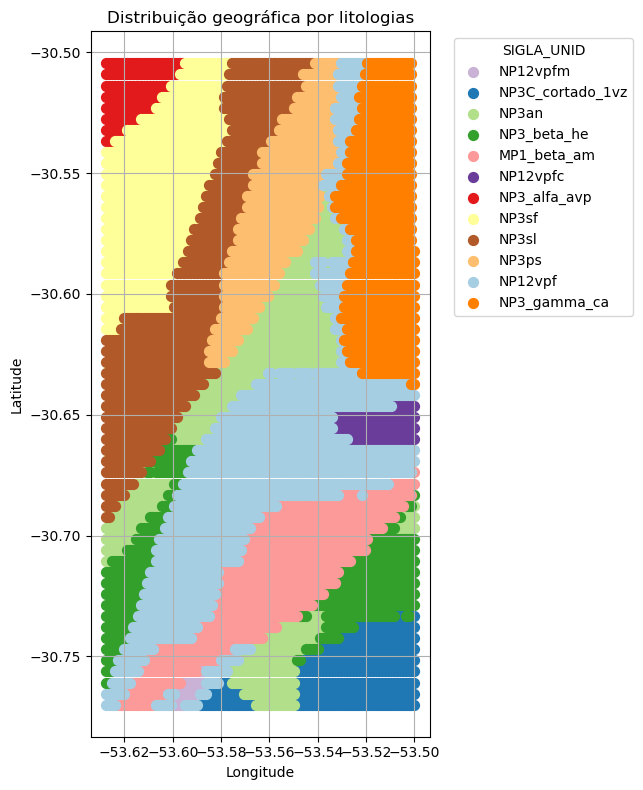

In [14]:


# Primeiro, vamos criar um dicionário de cores único para todas as siglas
all_siglas = pd.concat([df['SIGLA_AGG'], df['SIGLA_UNID']]).unique()
cores = plt.cm.Paired(np.linspace(0, 1, len(all_siglas)))
color_dict = {sigla: cores[i] for i, sigla in enumerate(all_siglas)}

# Função para plotar com cores consistentes usando geopandas
def plot_map(coluna, titulo):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot usando geopandas
    for sigla in df[coluna].unique():
        subset = df[df[coluna] == sigla]
        subset.plot(ax=ax, color=color_dict[sigla], label=sigla, markersize=50)
    
    # Adicionar elementos do mapa
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(titulo)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=coluna)
    
    # Adicionar grid e ajustar layout
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# Plotando os mapas
plot_map('SIGLA_AGG', 'Distribuição geográfica para litologias agregadas')
plot_map('SIGLA_UNID', 'Distribuição geográfica por litologias')

In [15]:
# Listar tipos de dados de cada coluna
print(df.dtypes)

# Ou identificar colunas não numéricas
non_numeric = df.select_dtypes(exclude=['number']).columns
print("Colunas não numéricas:", list(non_numeric))

fid                      int64
lon                    float64
lat                    float64
TC                     float64
Kperc                  float64
eU                     float64
eTh                    float64
U_Th                   float64
U_K                    float64
Th_K                   float64
MDT                    float64
COD_UNI_ES             float64
SIGLA_UNID              object
LS9_B6_SWIR            float64
LS9_B5_NIR             float64
LS9_B4_Red             float64
LS9_B3_Green           float64
LS9_B2_Blue            float64
LS9_B7_SWIR2           float64
LS9_RGB_Falsacor_1     float64
LS9_RGB_Falsacor_2     float64
LS9_RGB_Falsacor_3     float64
geometry              geometry
NDVI                   float64
Ratio_B5_B4            float64
Ratio_B7_B6            float64
SIGLA_AGG               object
dtype: object
Colunas não numéricas: ['SIGLA_UNID', 'geometry', 'SIGLA_AGG']


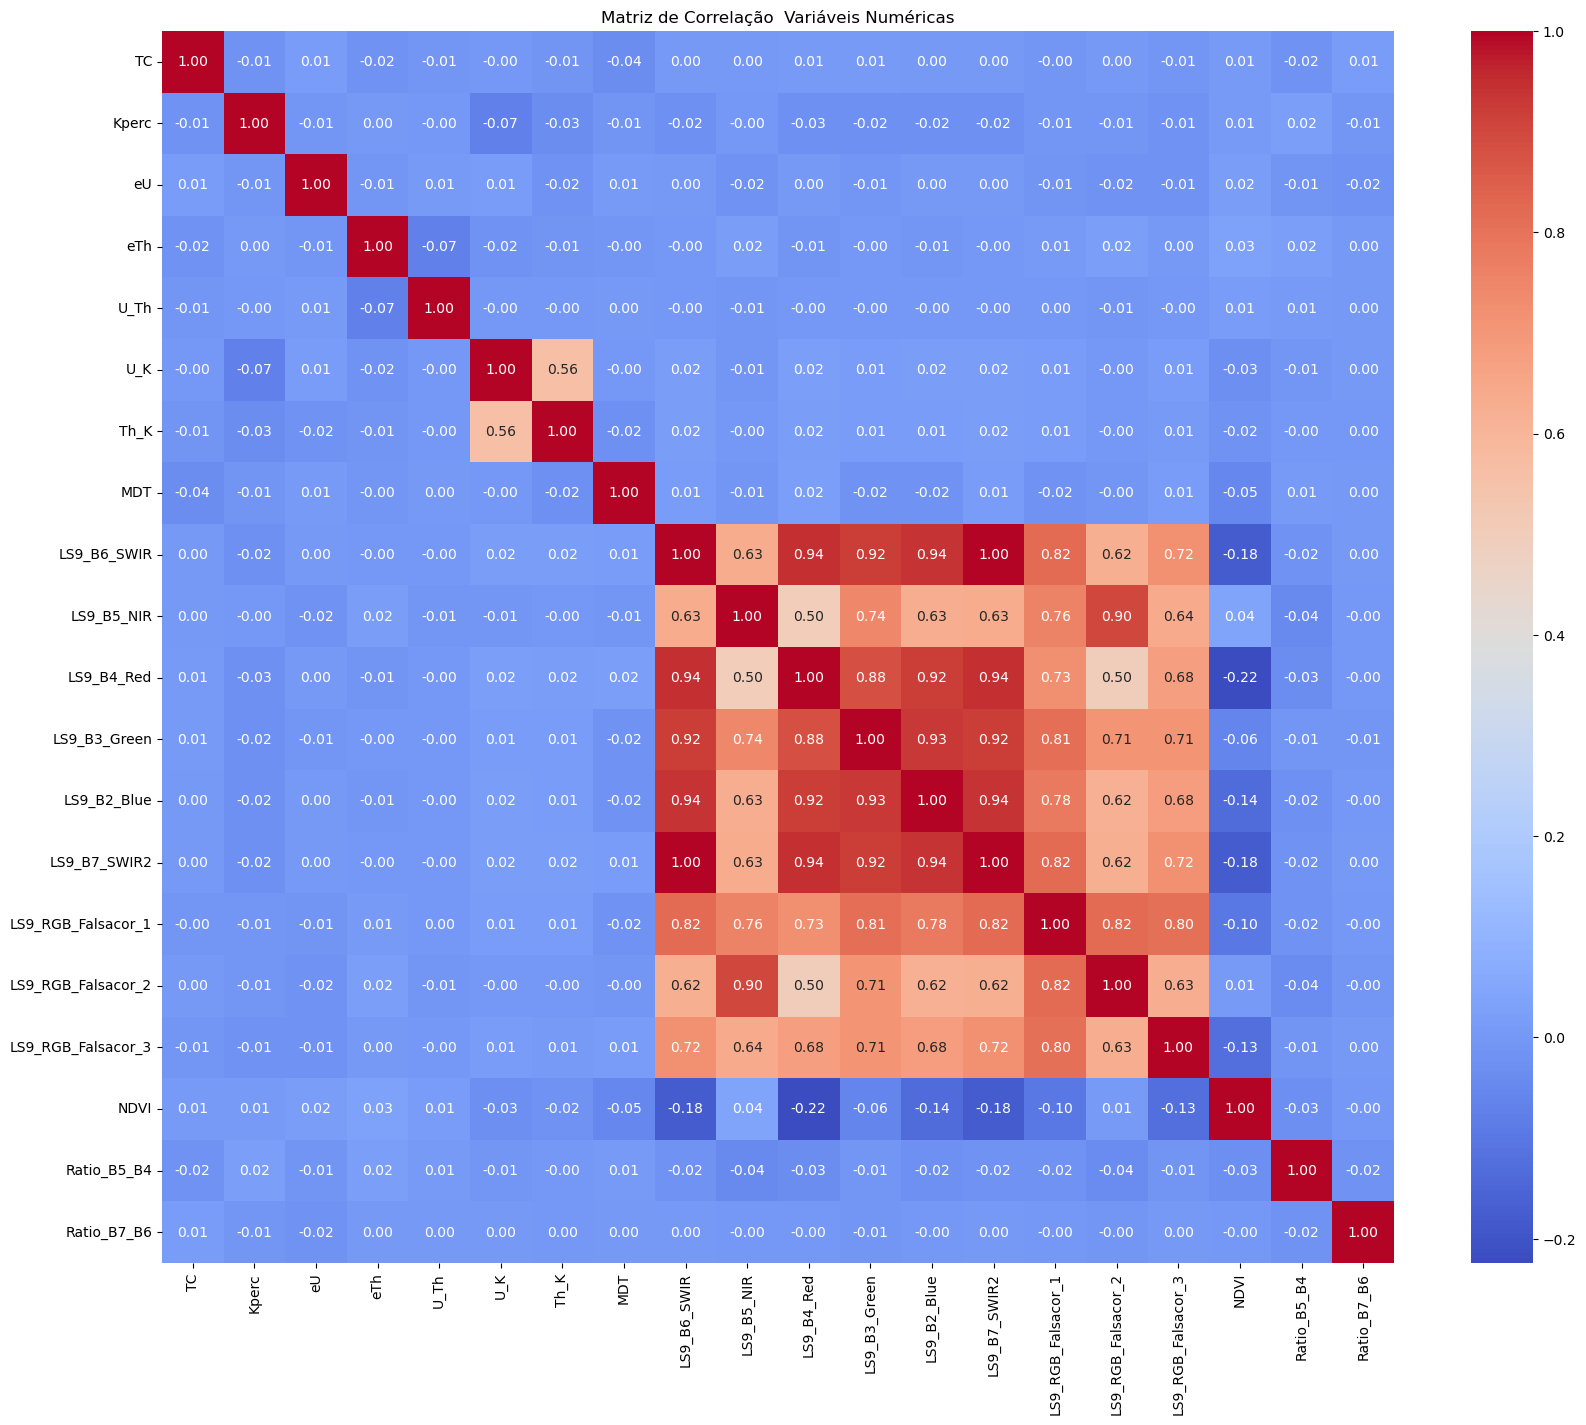

In [16]:
# Selecionar apenas colunas numéricas
numeric_df = df.select_dtypes(include=['number'])

# Remover colunas específicas que não queremos 
cols_to_drop = ['fid', 'lon', 'lat', 'COD_UNI_ES']  
numeric_df = numeric_df.drop([col for col in cols_to_drop if col in numeric_df.columns], axis=1)

# Calcular a matriz de correlação
corr_matrix = numeric_df.corr()

# Plotar
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Matriz de Correlação  Variáveis Numéricas')
plt.show()

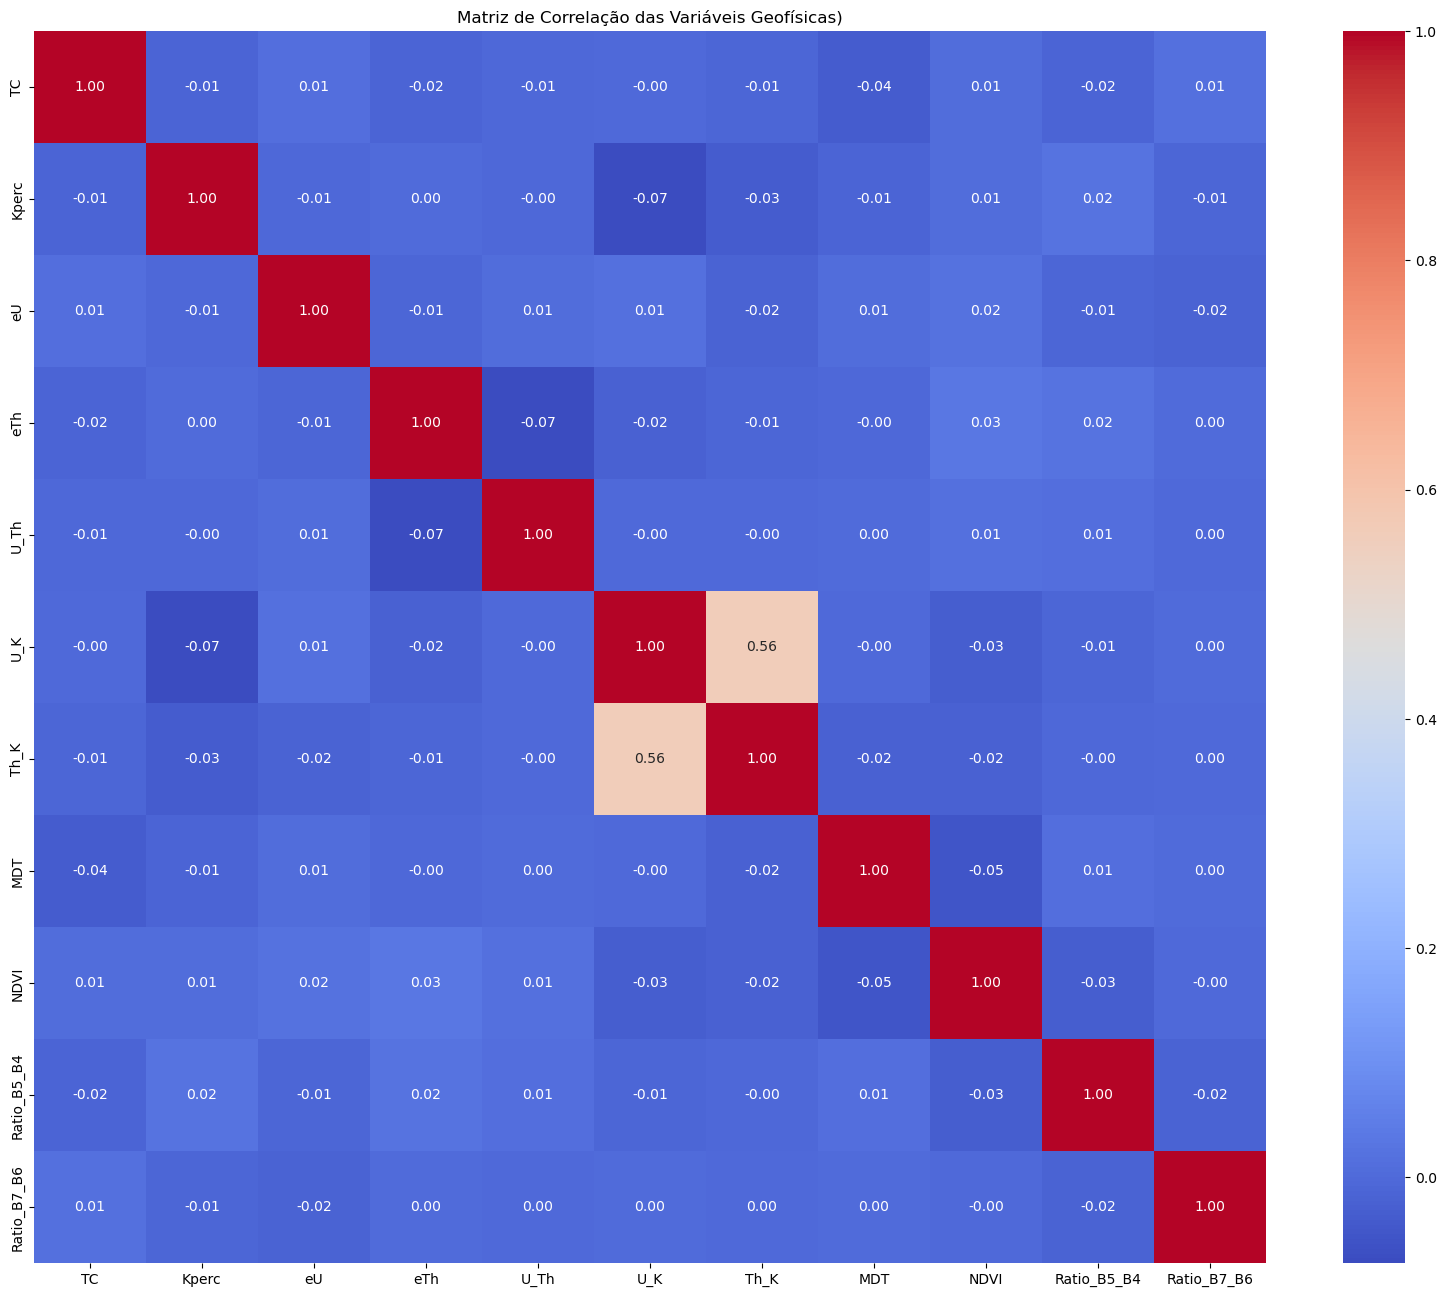

In [17]:
# Selecionar apenas colunas numéricas
numeric_df = df.select_dtypes(include=['number'])

# Remover colunas específicas que não queremos 
cols_to_drop = ['fid', 'lon', 'lat', 'SIGLA_AGG', 'COD_UNI_ES', 'LS9_B6_SWIR',
 'LS9_B5_NIR',
 'LS9_B4_Red',
 'LS9_B3_Green',
 'LS9_B2_Blue',
 'LS9_B7_SWIR2',
 'LS9_RGB_Falsacor_1',
 'LS9_RGB_Falsacor_2',
 'LS9_RGB_Falsacor_3']  
numeric_df = numeric_df.drop([col for col in cols_to_drop if col in numeric_df.columns], axis=1)

# Calcular a matriz de correlação
corr_matrix = numeric_df.corr()

# Plotar
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Matriz de Correlação das Variáveis Geofísicas)')
plt.show()




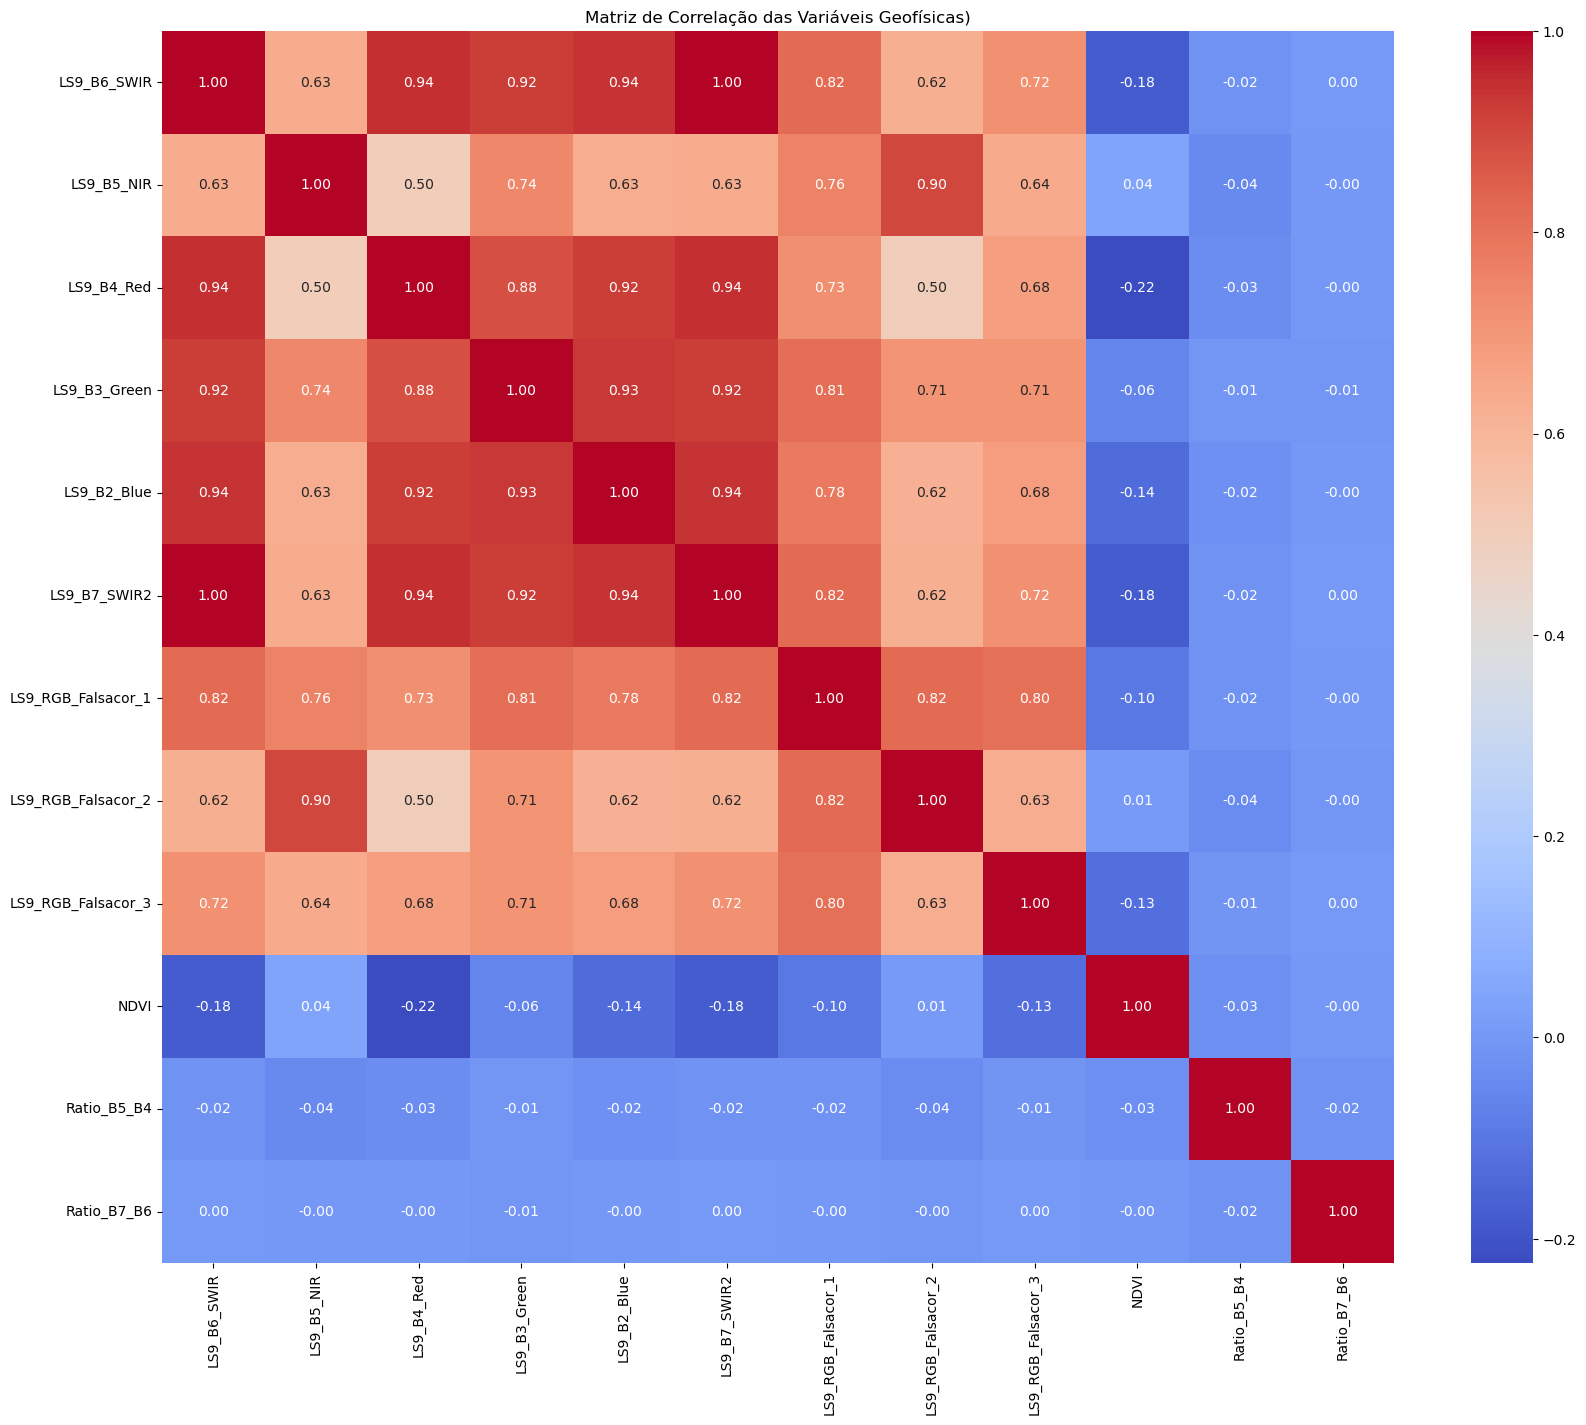

In [18]:
# Selecionar apenas colunas numéricas
numeric_df = df.select_dtypes(include=['number'])

# Remover colunas específicas que não queremos 
cols_to_drop = ['fid', 'lon', 'lat', 'SIGLA_AGG', 'COD_UNI_ES','TC',
 'Kperc',
 'eU',
 'eTh',
 'U_Th',
 'U_K',
 'Th_K',
 'MDT'] 
numeric_df = numeric_df.drop([col for col in cols_to_drop if col in numeric_df.columns], axis=1)

# Calcular a matriz de correlação
corr_matrix = numeric_df.corr()

# Plotar
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, fmt='.2f')
plt.title('Matriz de Correlação das Variáveis Geofísicas)')
plt.show()


### Criando o modelo a partir do Random Forest

In [19]:
# Definindo X e y (todas as amostras)
X = df.drop(['fid','SIGLA_AGG', 'COD_UNI_ES'], axis=1)  # Exclui target + IDs
y = df['SIGLA_AGG'] 

# Verificação global
print("Variáveis preditoras (X):", X.columns.tolist())
print("Variável target (y):", y.name)
print("\nShape de X (todas amostras):", X.shape)
print("Shape de y (todas amostras):", y.shape)
print("\nDistribuição original das classes:\n", y.value_counts())

Variáveis preditoras (X): ['lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 'MDT', 'SIGLA_UNID', 'LS9_B6_SWIR', 'LS9_B5_NIR', 'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2', 'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3', 'geometry', 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']
Variável target (y): SIGLA_AGG

Shape de X (todas amostras): (6237, 24)
Shape de y (todas amostras): (6237,)

Distribuição original das classes:
 SIGLA_AGG
NP3ps               2022
NP12vpf             1386
NP3an                658
NP3_gamma_ca         646
MP1_beta_am          639
NP3_beta_he          431
NP3C_cortado_1vz     323
NP3_alfa_avp         132
Name: count, dtype: int64


In [20]:
# 1. Definindo features e target
features = [  'lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K',
            'Th_K', 'MDT', 'LS9_B6_SWIR', 'LS9_B5_NIR', 
            'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2',
            'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3'
            , 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']
target = 'SIGLA_AGG' 

# 2. Amostragem estratificada - garantindo 150 por classe no treino
train_data = pd.DataFrame()

for classe in df[target].unique():
    classe_df = df[df[target] == classe]
    
    if len(classe_df) >= 150:
        # Pegar 150 para treino e o resto vai para teste
        train_classe = classe_df.sample(n=150, random_state=42)
        train_data = pd.concat([train_data, train_classe])
    else:
        # Se menos que 150, usar 70% para treino
        train_classe, _ = train_test_split(classe_df, train_size=0.7, random_state=42)
        train_data = pd.concat([train_data, train_classe])

# 3. Conjunto de teste
test_data = df[~df.index.isin(train_data.index)]

# 4. Separar features e target
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# 5. Verificação
print(f"Treino: {len(X_train)} amostras")
print(f"Teste: {len(X_test)} amostras")
print("\nDistribuição no treino:")
print(y_train.value_counts())
print("\nDistribuição no teste:")
print(y_test.value_counts())

Treino: 1142 amostras
Teste: 5095 amostras

Distribuição no treino:
SIGLA_AGG
NP12vpf             150
NP3C_cortado_1vz    150
NP3an               150
NP3_beta_he         150
MP1_beta_am         150
NP3ps               150
NP3_gamma_ca        150
NP3_alfa_avp         92
Name: count, dtype: int64

Distribuição no teste:
SIGLA_AGG
NP3ps               1872
NP12vpf             1236
NP3an                508
NP3_gamma_ca         496
MP1_beta_am          489
NP3_beta_he          281
NP3C_cortado_1vz     173
NP3_alfa_avp          40
Name: count, dtype: int64


In [21]:
print("Features usadas no treino:", X_train.columns.tolist())

Features usadas no treino: ['lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 'MDT', 'LS9_B6_SWIR', 'LS9_B5_NIR', 'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2', 'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3', 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']


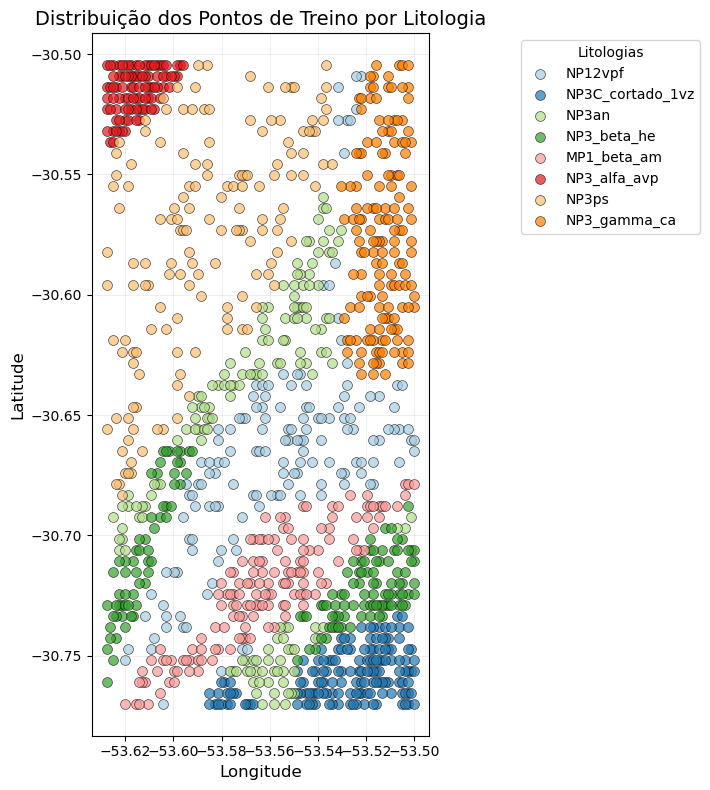

In [22]:
# Configuração das cores das litologias (compartilhada entre as células)
litologias_unicas = pd.concat([df['SIGLA_AGG'], df['SIGLA_UNID']]).unique()
cores = plt.cm.Paired(np.linspace(0, 1, len(litologias_unicas)))  # Paleta "Paired" do matplotlib
color_dict = {litologia: cores[i] for i, litologia in enumerate(litologias_unicas)}

# Visualização dos dados de treino - Versão otimizada para GeoDataFrame
plt.figure(figsize=(12, 8))
ax = plt.gca()  # Get current axis

# Usando plot do GeoDataFrame para melhor performance
for litologia in train_data[target].unique():
    subset = train_data[train_data[target] == litologia]
    subset.plot(
        ax=ax,
        color=color_dict[litologia],  # Mesma cor para cada litologia
        label=litologia, 
        markersize=50, 
        alpha=0.7,
        edgecolor='k',  
        linewidth=0.5
    )
    
plt.legend(bbox_to_anchor=(1.25, 1), title='Litologias', fontsize=10)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.title('Distribuição dos Pontos de Treino por Litologia', fontsize=14)
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

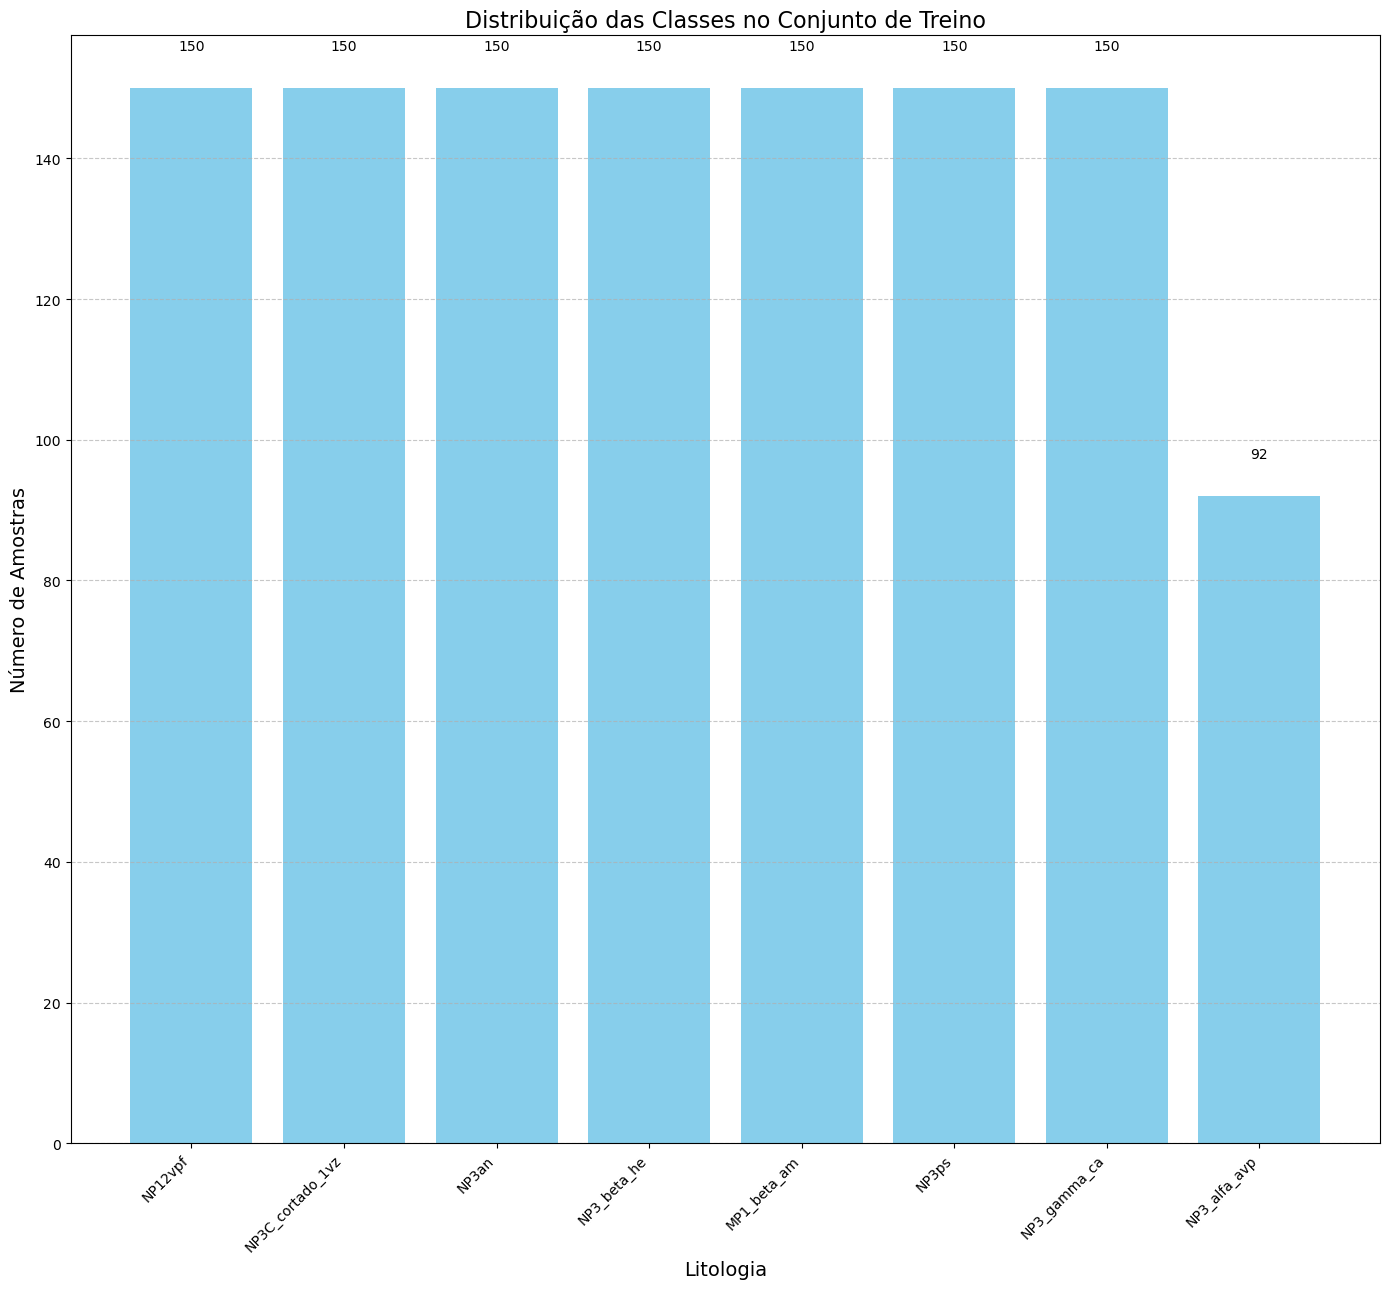

In [23]:
# Preparar os dados
class_dist = y_train.value_counts().reset_index()
class_dist.columns = ['Litologia', 'Quantidade']
class_dist = class_dist.sort_values('Quantidade', ascending=False)

# Criar figura
plt.figure(figsize=(14, 13))

#  Gráfico de barras simples (matplotlib)
plt.bar(class_dist['Litologia'], class_dist['Quantidade'], color='skyblue')
plt.title('Distribuição das Classes no Conjunto de Treino', fontsize=16)
plt.xlabel('Litologia', fontsize=14)
plt.ylabel('Número de Amostras', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar valores nas barras
for i, value in enumerate(class_dist['Quantidade']):
    plt.text(i, value + 5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()



In [24]:
df_treino = train_data

# Save to CSV
df_treino.to_csv('treino_PFeio_AGG.csv', index=False)

print('CSV salvo com sucesso')

CSV salvo com sucesso


In [25]:
feature_names = X_train.columns.tolist()  # Nomes antes do SMOTE

### SMOTE

In [26]:

#smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
#X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)
X_train_smt, y_train_smt = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42).fit_resample(X_train, y_train)

In [27]:
print("Features após SMOTE:", X_train_smt.columns.tolist())
print("Features originais:", feature_names)
assert X_train_smt.columns.tolist() == feature_names, "SMOTE alterou a ordem das features!"

Features após SMOTE: ['lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 'MDT', 'LS9_B6_SWIR', 'LS9_B5_NIR', 'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2', 'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3', 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']
Features originais: ['lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 'MDT', 'LS9_B6_SWIR', 'LS9_B5_NIR', 'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2', 'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3', 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']


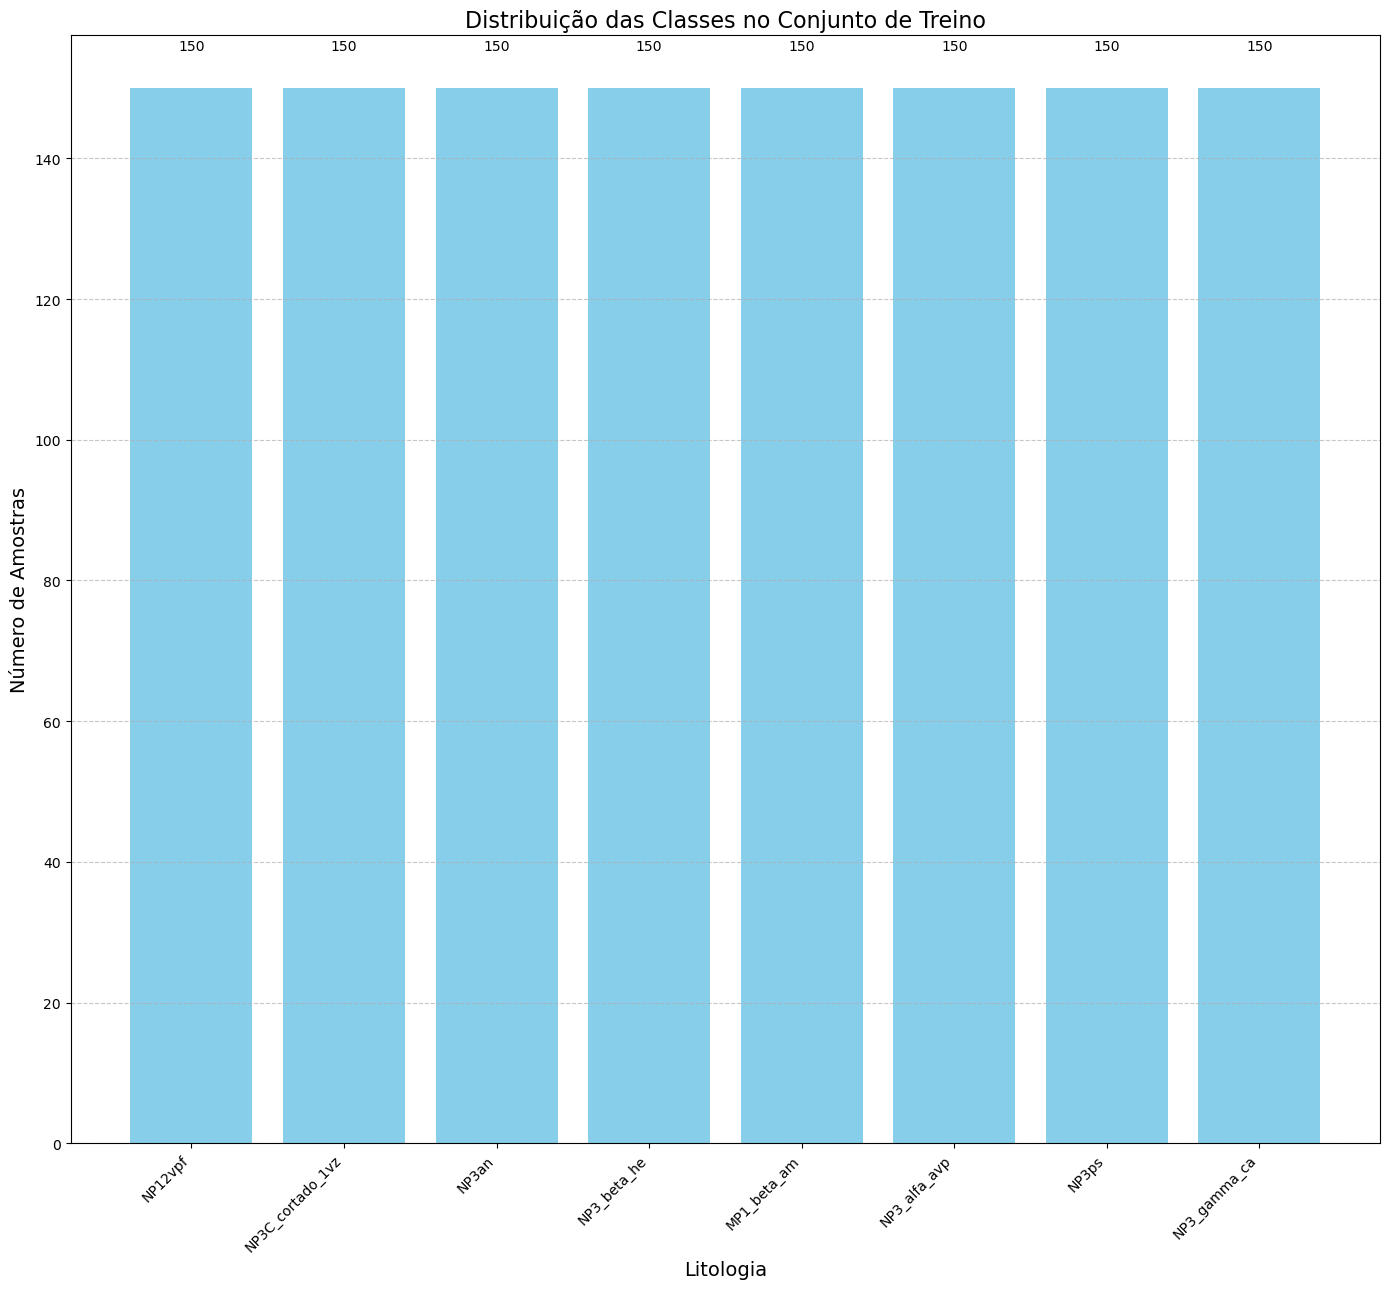

In [28]:
class_dist = y_train_smt.value_counts().reset_index()
class_dist.columns = ['Litologia', 'Quantidade']
class_dist = class_dist.sort_values('Quantidade', ascending=False)

# Criar figura
plt.figure(figsize=(14, 13))

# Gráfico de barras simples (matplotlib)
plt.bar(class_dist['Litologia'], class_dist['Quantidade'], color='skyblue')
plt.title('Distribuição das Classes no Conjunto de Treino', fontsize=16)
plt.xlabel('Litologia', fontsize=14)
plt.ylabel('Número de Amostras', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar valores nas barras
for i, value in enumerate(class_dist['Quantidade']):
    plt.text(i, value + 5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()



### Verificaçção dos dados após o SMOTE

In [29]:

X_pred = df[features].copy() 

# Verifique valores nulos
print("Valores nulos por feature:")
print(X_pred.isnull().sum())



Valores nulos por feature:
lon                   0
lat                   0
TC                    0
Kperc                 0
eU                    0
eTh                   0
U_Th                  0
U_K                   0
Th_K                  0
MDT                   0
LS9_B6_SWIR           0
LS9_B5_NIR            0
LS9_B4_Red            0
LS9_B3_Green          0
LS9_B2_Blue           0
LS9_B7_SWIR2          0
LS9_RGB_Falsacor_1    0
LS9_RGB_Falsacor_2    0
LS9_RGB_Falsacor_3    0
NDVI                  0
Ratio_B5_B4           0
Ratio_B7_B6           0
dtype: int64


In [30]:
missing = [f for f in features if f not in df.columns]
if missing:
    print(f"ERRO CRÍTICO: Features faltando: {missing}")
    print("Soluções possíveis:")
    print("1. Adicione as features faltantes ao DataFrame")
    print("2. Retreine o modelo sem essas features")
    raise ValueError("Features inconsistentes")
else:
    print("Todas as features presentes - pode prosseguir com a predição")

Todas as features presentes - pode prosseguir com a predição


In [31]:
# Pipeline com pré-processamento
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Menos sensível a outliers que StandardScaler
    ('classifier', RandomForestClassifier(
        random_state=42,
        class_weight='balanced_subsample'  # Versão melhorada para RF
    ))
])

# Grade de parâmetros expandida
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__max_features': ['sqrt']  # Adicionado controle de features
}

# Usando validação cruzada estratificada e balanced_accuracy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='balanced_accuracy',  # Melhor para classes desbalanceadas
    n_jobs=-1,
    verbose=2  
)

grid_search.fit(X_train_smt, y_train_smt)  # Usando dados balanceados

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced_subsample',
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__max_features': ['sqrt'],
                         'classifier__min_samples_leaf': [1, 2],
                         'classifier__min_samples_split': [2, 5],
                         'classifier__n_estimators': [100, 200]},
             scoring='balanced_accuracy', verbose=2)

In [32]:

# OBTER FEATURES REAIS USADAS NO TREINO

features_reais = grid_search.best_estimator_.named_steps['scaler'].feature_names_in_
print("Features usadas pelo modelo:", features_reais)


# PREPARAR DADOS PARA PREDIÇÃO

# Verificar se todas as features estão no DataFrame
missing = [f for f in features_reais if f not in df.columns]
if missing:
    raise ValueError(f"Features faltando no DataFrame: {missing}")

X_pred = df[features_reais].copy()
X_pred.fillna(X_pred.median(), inplace=True)  # Tratar valores nulos


# 3. FAZER PREDIÇÕES

df['RF_Prediction'] = grid_search.best_estimator_.predict(X_pred)
print("Predições adicionadas ao DataFrame!")

Features usadas pelo modelo: ['lon' 'lat' 'TC' 'Kperc' 'eU' 'eTh' 'U_Th' 'U_K' 'Th_K' 'MDT'
 'LS9_B6_SWIR' 'LS9_B5_NIR' 'LS9_B4_Red' 'LS9_B3_Green' 'LS9_B2_Blue'
 'LS9_B7_SWIR2' 'LS9_RGB_Falsacor_1' 'LS9_RGB_Falsacor_2'
 'LS9_RGB_Falsacor_3' 'NDVI' 'Ratio_B5_B4' 'Ratio_B7_B6']
Predições adicionadas ao DataFrame!


In [33]:
best_model = grid_search.best_estimator_
df['RF_Prediction'] = best_model.predict(X_pred)

# Fazer previsões no conjunto de teste
y_pred = best_model.predict(X_test)  
y_proba = best_model.predict_proba(X_test)  

# Métricas básicas
print(f"Melhores parâmetros: {grid_search.best_params_}\n")
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"Acurácia Balanceada: {balanced_accuracy_score(y_test, y_pred):.4f}\n")
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

Melhores parâmetros: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Acurácia: 0.7845
Acurácia Balanceada: 0.8214

Relatório de Classificação:
                   precision    recall  f1-score   support

     MP1_beta_am     0.5692    0.7321    0.6404       489
         NP12vpf     0.8709    0.5947    0.7067      1236
NP3C_cortado_1vz     0.7746    0.9538    0.8549       173
    NP3_alfa_avp     0.7500    0.9750    0.8478        40
     NP3_beta_he     0.4365    0.8078    0.5668       281
    NP3_gamma_ca     0.8330    0.9859    0.9030       496
           NP3an     0.5974    0.6339    0.6151       508
           NP3ps     0.9714    0.8878    0.9277      1872

        accuracy                         0.7845      5095
       macro avg     0.7254    0.8214    0.7578      5095
    weighted avg     0.8197    0.7845    0.7900      5095



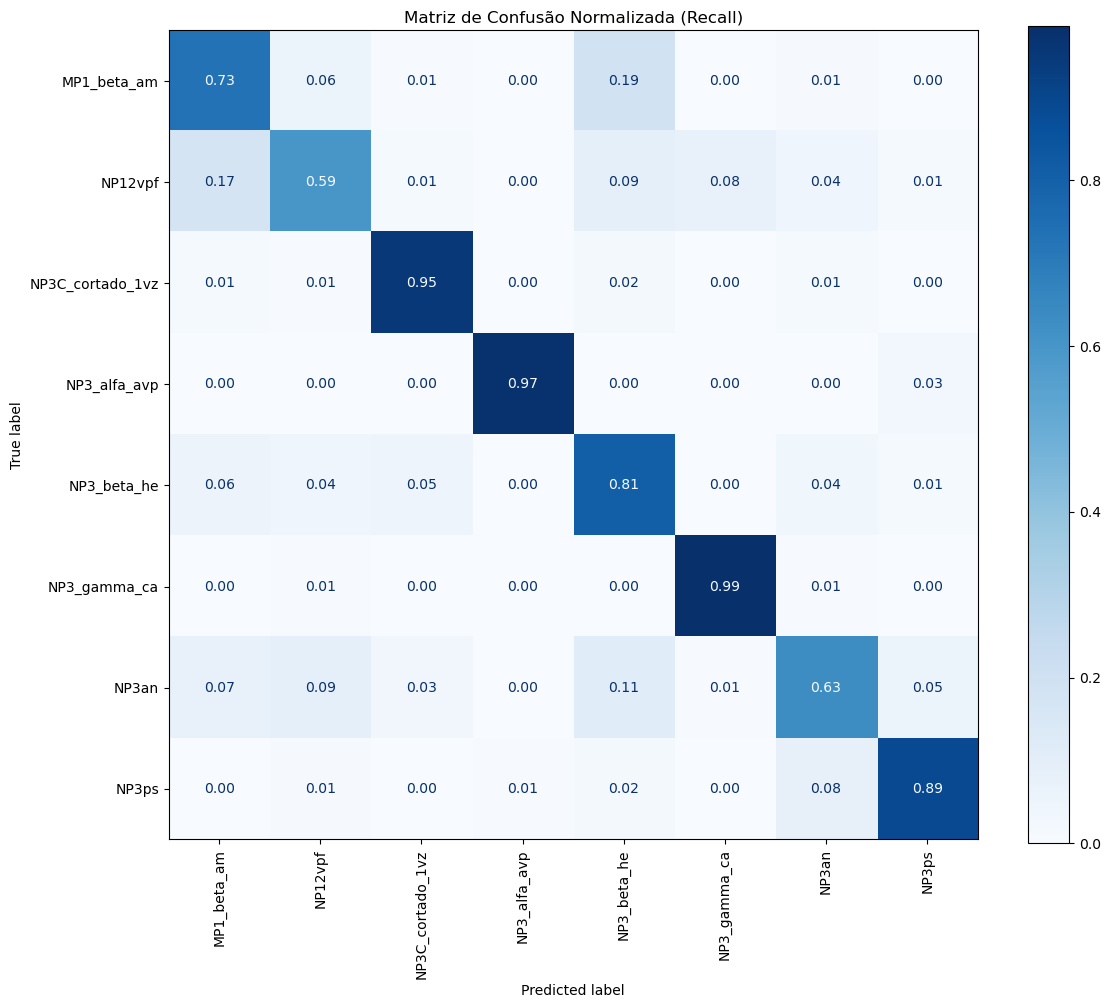

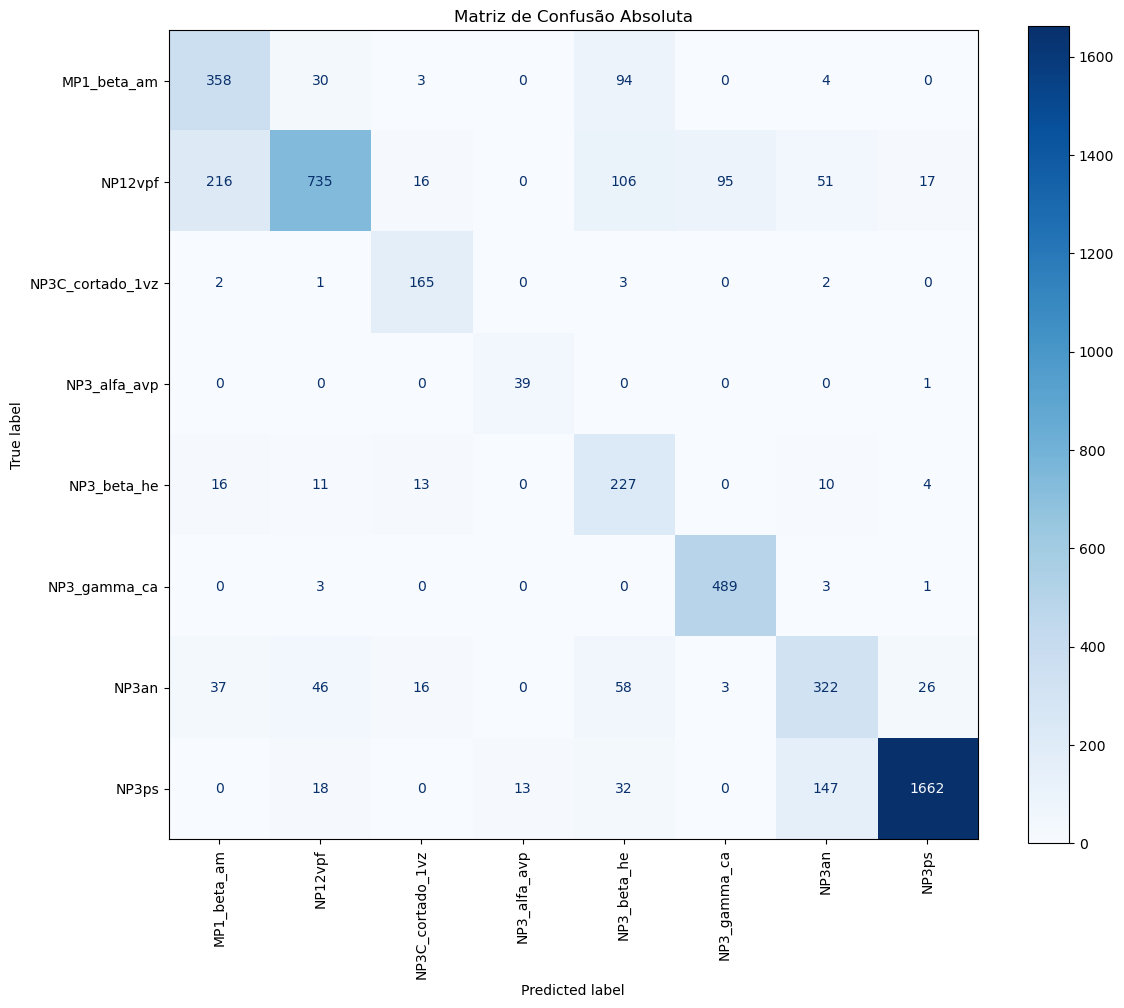

In [34]:
# Matriz de confusão normalizada por linha (recall)
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    normalize='true',
    cmap='Blues',
    ax=ax,
    values_format='.2f',
    xticks_rotation=90
)
plt.title('Matriz de Confusão Normalizada (Recall)')
plt.tight_layout()
plt.show()

# Matriz de confusão absoluta
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap='Blues',
    ax=ax,
    values_format='d',
    xticks_rotation=90
)
plt.title('Matriz de Confusão Absoluta')
plt.tight_layout()
plt.show()

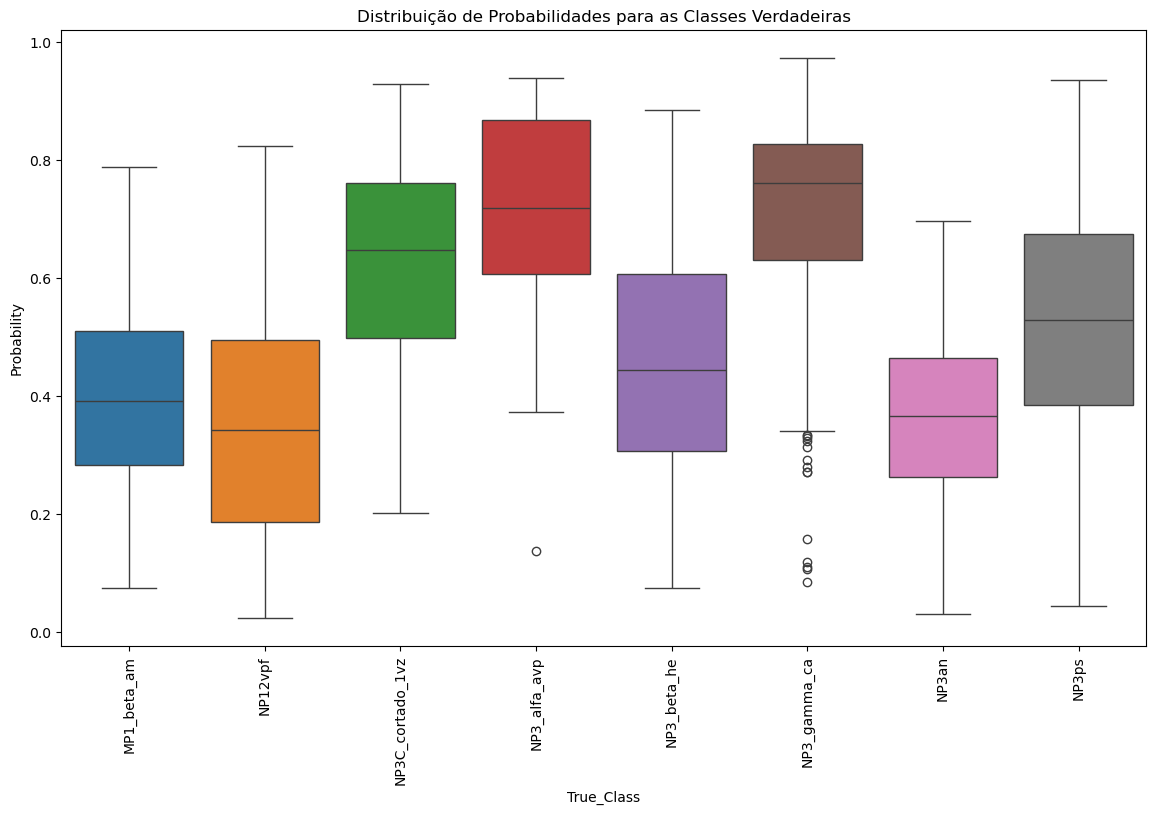

In [35]:
# Usando o modelo otimizado que você treinou
best_model = grid_search.best_estimator_  

# Obter as probabilidades e previsões
y_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

# DataFrame com probabilidades:
# Use best_model.classes_ para os nomes das colunas
prob_df = pd.DataFrame(y_proba, columns=best_model.classes_)
prob_df['True_Class'] = y_test.reset_index(drop=True)
prob_df['Predicted_Class'] = y_pred

# Visualização
melted_probs = prob_df.melt(id_vars=['True_Class', 'Predicted_Class'], 
                           var_name='Class', 
                           value_name='Probability')

plt.figure(figsize=(14, 8))
sns.boxplot(x='True_Class', y='Probability', hue='Class', 
            data=melted_probs[melted_probs['Class'] == melted_probs['True_Class']])
plt.title('Distribuição de Probabilidades para as Classes Verdadeiras')
plt.xticks(rotation=90)
plt.legend([], [], frameon=False)
plt.show()

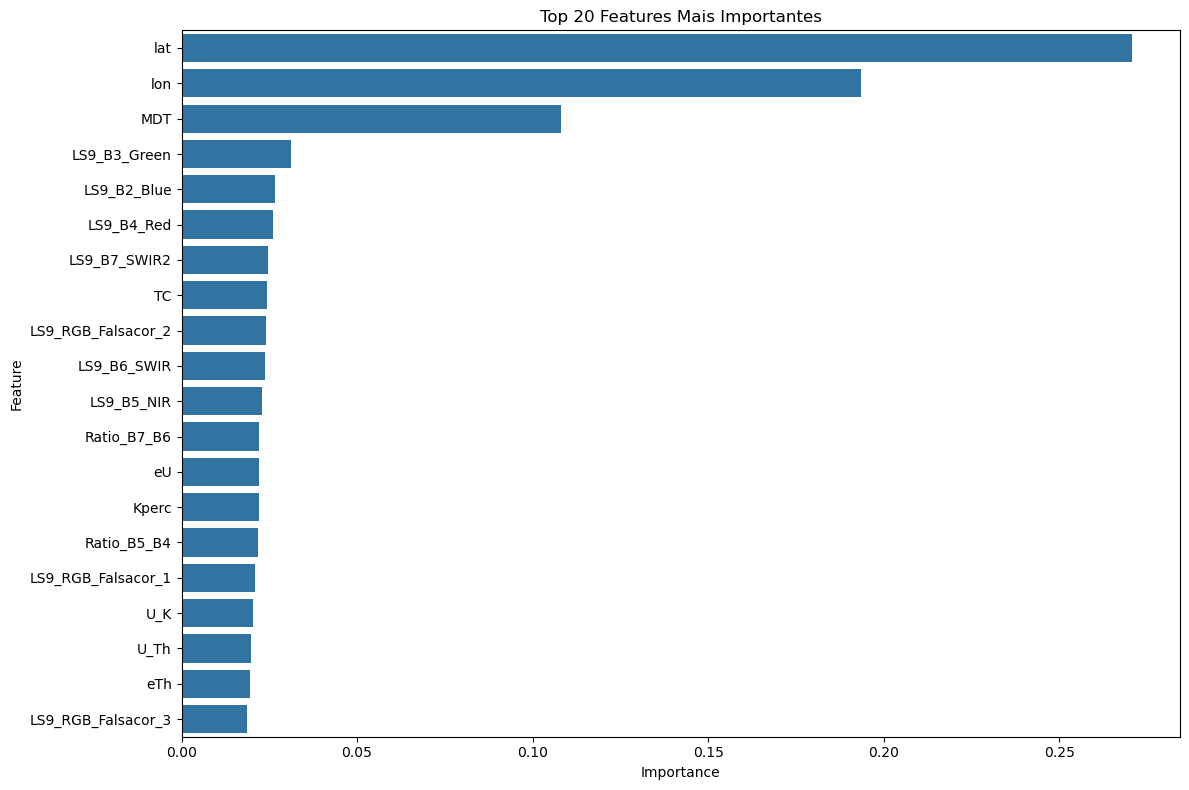

In [36]:
# Extrair importância das features do melhor modelo do GridSearch
best_model = grid_search.best_estimator_

# Acessar o classificador dentro do pipeline
importances = best_model.named_steps['classifier'].feature_importances_
features = features_reais  # Usando as features que foram realmente usadas no treino

feature_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_imp = feature_imp.sort_values('Importance', ascending=False)

# Plotar top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
plt.title('Top 20 Features Mais Importantes')
plt.tight_layout()
plt.show()

# Salvar importância para análise
feature_imp.to_csv('feature_importance.csv', index=False)

In [37]:
# Ajuste de thresholds por classe
best_model = grid_search.best_estimator_
rf_classifier = best_model.named_steps['classifier']  # Acessa o RandomForest dentro do pipeline

thresholds = {}
for i, cls in enumerate(rf_classifier.classes_):
    precision, recall, thresh = precision_recall_curve(y_test == cls, y_proba[:, i])
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)
    optimal_idx = np.argmax(f1)
    thresholds[cls] = thresh[optimal_idx]

# Aplicar novos thresholds
y_pred_adj = np.array([rf_classifier.classes_[i] for i in np.argmax(
    y_proba > np.array([thresholds[cls] for cls in rf_classifier.classes_]), axis=1)])

print("\nRelatório com Thresholds Ajustados:\n", classification_report(y_test, y_pred_adj))


Relatório com Thresholds Ajustados:
                   precision    recall  f1-score   support

     MP1_beta_am       0.41      0.88      0.56       489
         NP12vpf       0.79      0.62      0.69      1236
NP3C_cortado_1vz       0.93      0.87      0.90       173
    NP3_alfa_avp       0.89      0.85      0.87        40
     NP3_beta_he       0.61      0.58      0.59       281
    NP3_gamma_ca       0.91      0.94      0.93       496
           NP3an       0.60      0.56      0.58       508
           NP3ps       0.97      0.84      0.90      1872

        accuracy                           0.76      5095
       macro avg       0.76      0.77      0.75      5095
    weighted avg       0.81      0.76      0.77      5095



In [38]:
# 1. Ve que features usedforam usados no treino (scaler)
features_reais = grid_search.best_estimator_.named_steps['scaler'].feature_names_in_

# 2. Preparando os dados preditos
X_pred = df[features_reais].copy()
X_pred.fillna(X_pred.median(), inplace=True)  # Handle missing values same as training

# 3. Gerando as predições em cima do pipeline (scaler + classifier)
df['RF_Prediction'] = grid_search.best_estimator_.predict(X_pred)

# 4. Verificar os resultados
print("Predições geradas com sucesso!")
print("Features usadas:", features_reais.tolist())
print("\nDistribuição das classes preditas:")
print(df['RF_Prediction'].value_counts())

Predições geradas com sucesso!
Features usadas: ['lon', 'lat', 'TC', 'Kperc', 'eU', 'eTh', 'U_Th', 'U_K', 'Th_K', 'MDT', 'LS9_B6_SWIR', 'LS9_B5_NIR', 'LS9_B4_Red', 'LS9_B3_Green', 'LS9_B2_Blue', 'LS9_B7_SWIR2', 'LS9_RGB_Falsacor_1', 'LS9_RGB_Falsacor_2', 'LS9_RGB_Falsacor_3', 'NDVI', 'Ratio_B5_B4', 'Ratio_B7_B6']

Distribuição das classes preditas:
RF_Prediction
NP3ps               1861
NP12vpf              994
MP1_beta_am          779
NP3_gamma_ca         737
NP3an                689
NP3_beta_he          670
NP3C_cortado_1vz     363
NP3_alfa_avp         144
Name: count, dtype: int64


C:\Users\Matias\AppData\Local\Temp\ipykernel_13232\3934705392.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  df.to_file("predicoes_litologia_rf.shp")
c:\Users\Matias\anaconda3\envs\myenv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'LS9_B6_SWIR' to 'LS9_B6_SWI'
  ogr_write(
c:\Users\Matias\anaconda3\envs\myenv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'LS9_B3_Green' to 'LS9_B3_Gre'
  ogr_write(
c:\Users\Matias\anaconda3\envs\myenv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'LS9_B2_Blue' to 'LS9_B2_Blu'
  ogr_write(
c:\Users\Matias\anaconda3\envs\myenv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'LS9_B7_SWIR2' to 'LS9_B7_SWI'
  ogr_write(
c:\Users\Matias\anaconda3\envs\myenv\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field 

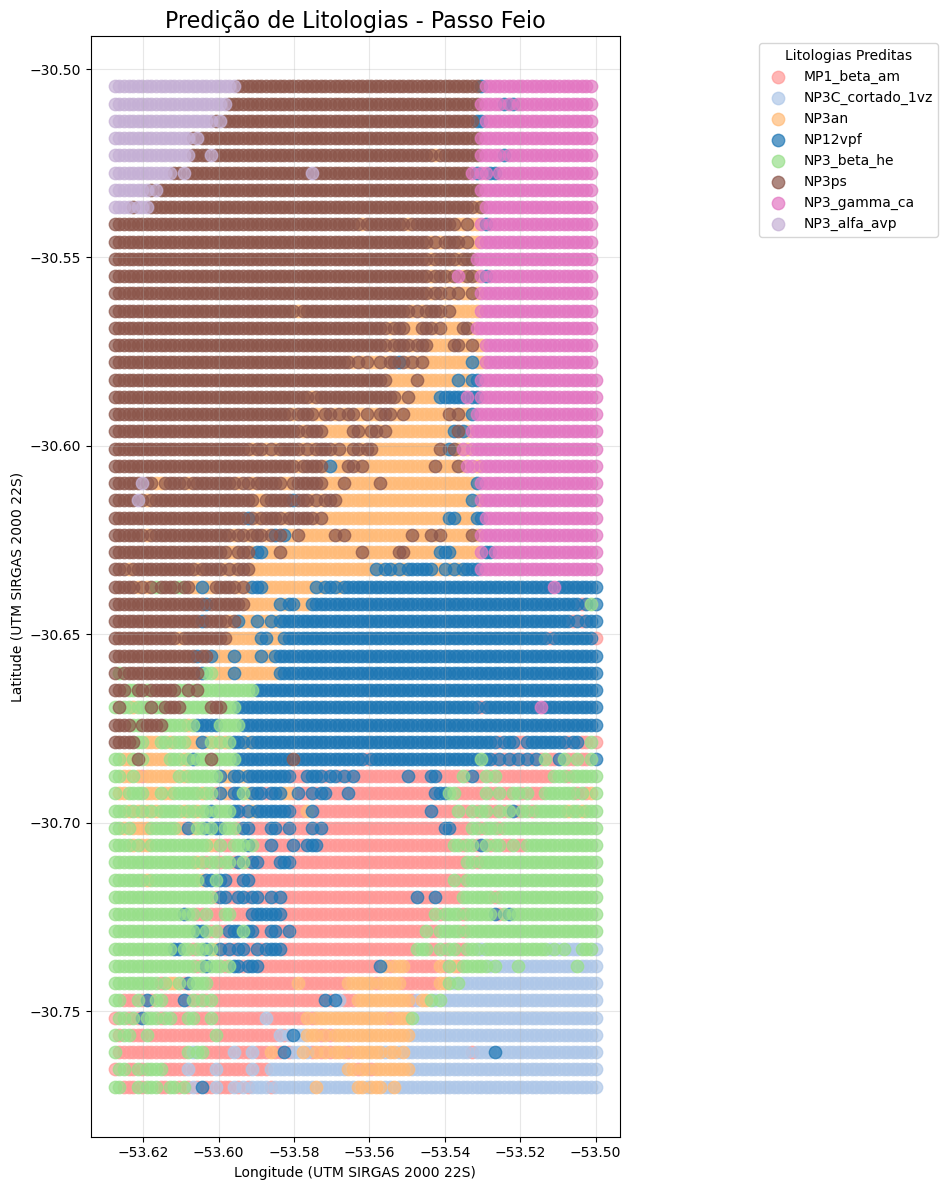

In [39]:
# 1. Configurar cores
litologias_unicas = pd.concat([df['SIGLA_AGG'], df['SIGLA_UNID']]).unique()
cores = plt.cm.tab20(np.linspace(0, 1, len(litologias_unicas)))
color_dict = {litologia: cores[i] for i, litologia in enumerate(litologias_unicas)}

# 2. Criar figura
fig, ax = plt.subplots(figsize=(15, 12))

# 3. Plotar cada litologia
for litologia in df['RF_Prediction'].unique():
    subset = df[df['RF_Prediction'] == litologia]
    subset.plot(ax=ax, color=color_dict[litologia], 
               label=litologia, markersize=80, alpha=0.7)

# 4. Elementos do mapa

ax.set_title('Predição de Litologias - Passo Feio', fontsize=16)
ax.set_xlabel('Longitude (UTM SIRGAS 2000 22S)')
ax.set_ylabel('Latitude (UTM SIRGAS 2000 22S)')
plt.legend(bbox_to_anchor=(1.25, 1), title='Litologias Preditas')
plt.grid(alpha=0.3)
plt.tight_layout()

# 5. Salvar
df.to_file("predicoes_litologia_rf.shp")
plt.savefig('mapa_predicoes_rf.tif', dpi=300, bbox_inches='tight')
plt.show()

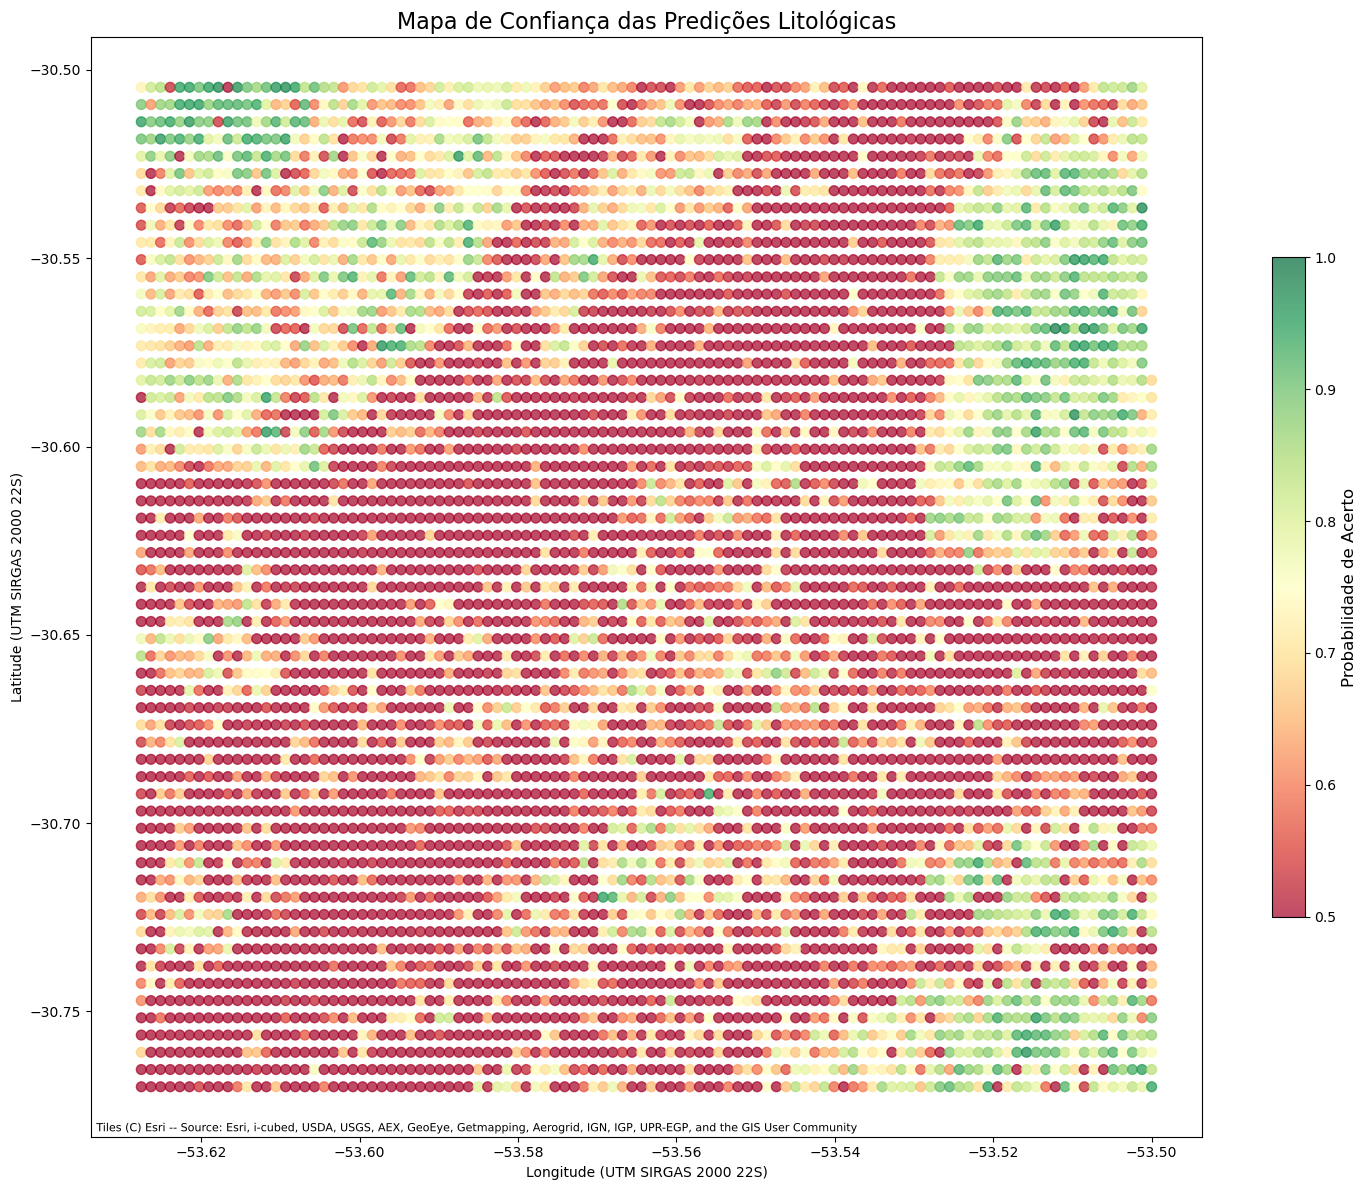

In [40]:
import matplotlib.pyplot as plt
import contextily as ctx

# 1. Obter probabilidades e calcular confiança
proba = grid_search.best_estimator_.predict_proba(X_pred)
df['RF_Confidence'] = np.max(proba, axis=1)

# 2. Criar figura
fig, ax = plt.subplots(figsize=(15, 12))

# 3. Plotar pontos
scatter = ax.scatter(df.geometry.x, df.geometry.y, 
                     c=df['RF_Confidence'], 
                     cmap='RdYlGn',
                     vmin=0.5, vmax=1.0,
                     s=50, alpha=0.7)

# 4. Adicionar basemap com CRS correto 
ctx.add_basemap(ax, 
               crs=df.crs.to_string(),  # Usar to_string() 
               source=ctx.providers.Esri.WorldImagery,
               alpha=0.4)

# 5. Configurações do mapa
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label('Probabilidade de Acerto', fontsize=12)
ax.set_title('Mapa de Confiança das Predições Litológicas', fontsize=16)
ax.set_xlabel('Longitude (UTM SIRGAS 2000 22S)')
ax.set_ylabel('Latitude (UTM SIRGAS 2000 22S)')

plt.tight_layout()
plt.savefig('mapa_confianca_rf.png', dpi=300, bbox_inches='tight')
plt.show()